In [2]:
import pandas as pd
from ast import literal_eval
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer, OneHotEncoder
from sklearn.model_selection import train_test_split
import xgboost as xgb
from xgboost import XGBRegressor
import category_encoders as ce
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from xgboost import plot_importance
import matplotlib.pyplot as plt
import seaborn as sns

### Load data

In [56]:
train = pd.read_csv('../tmdb-box-office-prediction/train.csv')
test = pd.read_csv('../tmdb-box-office-prediction/test.csv')
sample_submission = pd.read_csv('../tmdb-box-office-prediction/sample_submission.csv')

### Initial data exploration

In [57]:
# Not a lot of observations left in the train set. Hopefully it'll be 
# enough to train a decent model.

train.shape, test.shape, sample_submission.shape

((3000, 23), (4398, 22), (4398, 2))

In [58]:
# Many 0 values for budget
# 812 movies have 0 for budget in train, 1211 in test
train.describe()

,id,budget,popularity,runtime,revenue
count,3000.000000,3.000000e+03,3000.000000,2998.000000,3.000000e+03
mean,1500.500000,2.253133e+07,8.463274,107.856571,6.672585e+07
std,866.169729,3.702609e+07,12.104000,22.086434,1.375323e+08
min,1.000000,0.000000e+00,0.000001,0.000000,1.000000e+00
25%,750.750000,0.000000e+00,4.018053,94.000000,2.379808e+06
50%,1500.500000,8.000000e+06,7.374861,104.000000,1.680707e+07
75%,2250.250000,2.900000e+07,10.890983,118.000000,6.891920e+07
max,3000.000000,3.800000e+08,294.337037,338.000000,1.519558e+09


In [59]:
train.describe(exclude='number')

,belongs_to_collection,genres,homepage,imdb_id,original_language,original_title,overview,poster_path,production_companies,production_countries,release_date,spoken_languages,status,tagline,title,Keywords,cast,crew
count,604,2993,946,3000,3000,3000,2992,2999,2844,2945,3000,2980,3000,2403,3000,2724,2987,2984
unique,422,872,941,3000,36,2975,2992,2999,2383,321,2398,401,2,2400,2969,2648,2975,2984
top,"[{'id': 645, 'name': 'James Bond Collection', ...","[{'id': 18, 'name': 'Drama'}]",http://www.transformersmovie.com/,tt0117364,en,Logan,A young boy trying to deal with his mother's h...,/zongyslIHQmfnf9rgUioPkDaHmq.jpg,"[{'name': 'Paramount Pictures', 'id': 4}]","[{'iso_3166_1': 'US', 'name': 'United States o...",9/10/15,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Based on a true story.,Unknown,"[{'id': 10183, 'name': 'independent film'}]",[],"[{'credit_id': '5608046ac3a3681207004fdf', 'de..."
freq,16,266,4,1,2575,2,1,1,51,1752,5,1817,2996,3,2,27,13,1


In [60]:
train.head().T

,0,1,2,3,4
id,1,2,3,4,5
belongs_to_collection,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...","[{'id': 107674, 'name': 'The Princess Diaries ...",NaN,NaN,NaN
budget,14000000,40000000,3300000,1200000,0
genres,"[{'id': 35, 'name': 'Comedy'}]","[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...","[{'id': 18, 'name': 'Drama'}]","[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...","[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam..."
homepage,NaN,NaN,http://sonyclassics.com/whiplash/,http://kahaanithefilm.com/,NaN
imdb_id,tt2637294,tt0368933,tt2582802,tt1821480,tt1380152
original_language,en,en,en,hi,ko
original_title,Hot Tub Time Machine 2,The Princess Diaries 2: Royal Engagement,Whiplash,Kahaani,마린보이
overview,"When Lou, who has become the ""father of the In...",Mia Thermopolis is now a college graduate and ...,"Under the direction of a ruthless instructor, ...",Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,Marine Boy is the story of a former national s...
popularity,6.57539,8.24889,64.3,3.17494,1.14807


### Wrangle data

In [62]:
# wrangle function
def wrangle(X):
    
    # Convert columns with string representations of lists to lists (of dictionaries)
    # This is a common issue when saving and loading pandas DataFrames as .csv files.
    string_list = ['belongs_to_collection', 'genres', 'production_companies',
                   'production_countries', 'spoken_languages', 'Keywords', 
                   'cast', 'crew']

    for col in string_list:
        X.loc[:,col] = X.loc[:,col].apply(lambda x: literal_eval(x) 
                                          if type(x)==str else np.nan)
        
    # Add feature: 1 if movie belongs to a collection, 0 otherwise
    X['collection'] = X['belongs_to_collection'].notnull().astype(int)
    
    # Add feature: 1 if movie released, 0 otherwise
    X['released'] = X['status'].apply(lambda x: 1 if x=='Released' else 0)
    
    # Add feature: 1 if movie has a homepage, 0 otherwise
    # Might covary with budget
    X['has_homepage'] = X['homepage'].notnull().astype(int)
    
    # Get features for collection_id and collection_name
    X['collection_id'] = X['belongs_to_collection'].apply(lambda x: x[0]['id']
                                                          if type(x)==list else 0)
    X['collection_name'] = X['belongs_to_collection'].apply(lambda x: x[0]['name'] 
                                                            if type(x)==list else np.nan)
    
    # Create a feature that is release_date in datetime format
    # Extract year, month, day, dayofweek, and quarter. Drop datetime feature
    X['release_date_dt'] = pd.to_datetime(X['release_date'], infer_datetime_format=True)
    X['release_year'] = X['release_date_dt'].dt.year.apply(lambda x: 
                                                           x if x < 2020 
                                                           else x - 100)
    X['release_month'] = X['release_date_dt'].dt.month
    X['release_day'] = X['release_date_dt'].dt.day
    X['release_dayofweek'] = X['release_date_dt'].dt.dayofweek
    X['release_quarter'] = X['release_date_dt'].dt.quarter
    X = X.drop('release_date_dt', axis=1)
    
    # Get genre list for each movie
    X['list_of_genres'] = list(X['genres'].apply(lambda x: [i['name'] for i in x]
                                                 if type(x) == list
                                                 else []).values)
    
    # Create str feature with all genres of each movie
    X['all_genres'] = X['list_of_genres'].apply(lambda x: ", ".join(x))
    
    # One hot encode genre lists
    mlb = MultiLabelBinarizer()
    X = X.join(pd.DataFrame(mlb.fit_transform(X.pop('list_of_genres')),
                                              columns=mlb.classes_, index=X.index))

#     # Uncomment to create one-hot features for each language. Doesn't help model.  
#     top_languages = ['en', 'fr', 'ru', 'es', 'hi', 'ja', 'it', 'ko', 'cn', 'zh', 'de', 'ta']
    
#     for i in top_languages:
#         X['language_' + i] = X['original_language'].apply(lambda x: 1 if x==i else 0)
    
    X['original_english'] = X['original_language'].apply(lambda x: 1 if x=='en' else 0)
  
    # Gets string with name of first listed production company
    X['production_company'] = X['production_companies'].apply(lambda x: x[0]['name'] 
                                                            if type(x)==list else np.nan)
    return X


In [63]:
train_wrangled = wrangle(train)
test_wrangled = wrangle(test)

In [116]:
train_wrangled.head()

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,...,Horror,Music,Mystery,Romance,Science Fiction,Thriller,War,Western,original_english,production_company
0,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,...,0,0,0,0,0,0,0,0,1,Paramount Pictures
1,2,"[{'id': 107674, 'name': 'The Princess Diaries ...",40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,...,0,0,0,1,0,0,0,0,1,Walt Disney Pictures
2,3,NaN,3300000,"[{'id': 18, 'name': 'Drama'}]",http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,...,0,0,0,0,0,0,0,0,1,Bold Films
3,4,NaN,1200000,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",http://kahaanithefilm.com/,tt1821480,hi,Kahaani,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,3.174936,...,0,0,0,0,0,1,0,0,0,NaN
4,5,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",NaN,tt1380152,ko,마린보이,Marine Boy is the story of a former national s...,1.148070,...,0,0,0,0,0,1,0,0,0,NaN


In [65]:
# TV Movie has one occurence, only in train
train_wrangled.drop('TV Movie', axis=1, inplace=True)

In [66]:
train_wrangled.shape, test_wrangled.shape

((3000, 55), (4398, 54))

## Modeling

### Split into X feature matrix and y target vector

In [82]:
features = ['budget', 'runtime', 'collection', 'released',
            'has_homepage', 'collection_id', 'release_year', 'release_month', 
            'release_day', 'release_dayofweek', 'release_quarter', 'all_genres', 
            'Action', 'Adventure', 'Animation', 'Comedy', 'Crime', 
            'Documentary', 'Drama', 'Family', 'Fantasy', 'Foreign', 'History', 
            'Horror', 'Music', 'Mystery', 'Romance', 'Science Fiction', 
            'Thriller', 'War', 'Western', 'original_english', 'production_company']
target = 'revenue'

In [83]:
X = train_wrangled[features]
y = train_wrangled[target]
X_test = test_wrangled[features]

In [84]:
# train/test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1)
y_train_log = np.log1p(y_train)
y_val_log = np.log1p(y_val)
X_train.shape, X_val.shape, y_train.shape, y_val.shape, X_test.shape

((2700, 33), (300, 33), (2700,), (300,), (4398, 33))

### Make pipeline and fit it

In [85]:
# Make pipeline
# commented out the encoder because I believe wrangle() is taking care of it now
pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='median'),
    RandomForestRegressor(n_estimators=5000, random_state=42, n_jobs=-1)
)

In [86]:
# Fit
pipeline.fit(X_train, y_train_log)

Pipeline(memory=None,
     steps=[('ordinalencoder', OrdinalEncoder(cols=['all_genres', 'production_company'],
        drop_invariant=False, handle_missing='value',
        handle_unknown='value',
        mapping=[{'col': 'all_genres', 'mapping': Adventure, Comedy                                        1
Action, War          ...imators=5000, n_jobs=-1,
           oob_score=False, random_state=42, verbose=0, warm_start=False))])

### Validate

In [87]:
# evaluation functions
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def rmsle(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

In [88]:
# Validate
y_pred = pipeline.predict(X_val)
print('Validation Error', rmse(y_val_log, y_pred))

Validation Error 1.9178398029208354


### Generate predictions

In [89]:
# prediction function
def generate_submission(estimator, X_test_param, filename):
    y_pred_log = estimator.predict(X_test_param)
    y_pred = np.expm1(y_pred_log)  # Convert from log-dollars to dollars
    submission = pd.read_csv('../tmdb-box-office-prediction/sample_submission.csv')
    submission['revenue'] = y_pred
    submission.to_csv(filename, index=False)

In [90]:
# make predictions
# first Kaggle submission RMSE: 3.24910
generate_submission(pipeline, X_test, 'tmdb_sub_12.csv')

### XG Boost

In [91]:
# X_test has 1 NaN for each dt feature, 4 NaN for runtime
# I should probably just run an imputer on all of these
# what's the deal with simpleimputer returning an array 
# and iterativeimputer being experimental and impossible to import?
X_test = X_test.fillna(X_test.median())
X_train = X_train.fillna(X_test.median())

In [92]:
encoder = ce.OrdinalEncoder()
X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_val)
X_test_encoded = encoder.transform(X_test)

In [93]:
X_train_encoded.shape, X_val_encoded.shape, X_test_encoded.shape

((2700, 33), (300, 33), (4398, 33))

In [94]:
eval_set = [(X_train_encoded, y_train_log),
            (X_val_encoded, y_val_log)]

model = XGBRegressor(n_estimators=10000, n_jobs=-1, eta=0.001, max_depth=1)
model.fit(X_train_encoded, y_train_log, eval_set=eval_set, eval_metric='rmse',
         early_stopping_rounds=1000)

[0]	validation_0-rmse:14.2447	validation_1-rmse:14.1093
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 1000 rounds.
[1]	validation_0-rmse:12.8715	validation_1-rmse:12.7426
[2]	validation_0-rmse:11.64	validation_1-rmse:11.5134
[3]	validation_0-rmse:10.5371	validation_1-rmse:10.4092
[4]	validation_0-rmse:9.54997	validation_1-rmse:9.41719
[5]	validation_0-rmse:8.66765	validation_1-rmse:8.53679
[6]	validation_0-rmse:7.87979	validation_1-rmse:7.74519
[7]	validation_0-rmse:7.17792	validation_1-rmse:7.03877
[8]	validation_0-rmse:6.55387	validation_1-rmse:6.41527
[9]	validation_0-rmse:5.99984	validation_1-rmse:5.85969
[10]	validation_0-rmse:5.51014	validation_1-rmse:5.36796
[11]	validation_0-rmse:5.07806	validation_1-rmse:4.93313
[12]	validation_0-rmse:4.6986	validation_1-rmse:4.55142
[13]	validation_0-rmse:4.36587	validation_1-rmse:4.21899
[14]	validation_0-rmse:4.0755	validation_1-rmse:3.9248

/Users/stephensinclair/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21]	validation_0-rmse:2.90591	validation_1-rmse:2.73817
[22]	validation_0-rmse:2.823	validation_1-rmse:2.65506
[23]	validation_0-rmse:2.75358	validation_1-rmse:2.58685
[24]	validation_0-rmse:2.69539	validation_1-rmse:2.52862
[25]	validation_0-rmse:2.64651	validation_1-rmse:2.4779
[26]	validation_0-rmse:2.60559	validation_1-rmse:2.43624
[27]	validation_0-rmse:2.57152	validation_1-rmse:2.40375
[28]	validation_0-rmse:2.54302	validation_1-rmse:2.37435
[29]	validation_0-rmse:2.51899	validation_1-rmse:2.35119
[30]	validation_0-rmse:2.49872	validation_1-rmse:2.32819
[31]	validation_0-rmse:2.4814	validation_1-rmse:2.31088
[32]	validation_0-rmse:2.46674	validation_1-rmse:2.29572
[33]	validation_0-rmse:2.45442	validation_1-rmse:2.27715
[34]	validation_0-rmse:2.44376	validation_1-rmse:2.26706
[35]	validation_0-rmse:2.43438	validation_1-rmse:2.25654
[36]	validation_0-rmse:2.42627	validation_1-rmse:2.24969
[37]	validation_0-rmse:2.41929	validation_1-rmse:2.24301
[38]	validation_0-rmse:2.41304	vali

[165]	validation_0-rmse:2.25817	validation_1-rmse:2.11739
[166]	validation_0-rmse:2.25765	validation_1-rmse:2.11943
[167]	validation_0-rmse:2.25717	validation_1-rmse:2.1178
[168]	validation_0-rmse:2.25669	validation_1-rmse:2.1172
[169]	validation_0-rmse:2.25622	validation_1-rmse:2.11445
[170]	validation_0-rmse:2.25572	validation_1-rmse:2.11564
[171]	validation_0-rmse:2.25525	validation_1-rmse:2.11515
[172]	validation_0-rmse:2.25477	validation_1-rmse:2.11577
[173]	validation_0-rmse:2.25433	validation_1-rmse:2.11594
[174]	validation_0-rmse:2.25388	validation_1-rmse:2.11651
[175]	validation_0-rmse:2.25345	validation_1-rmse:2.11646
[176]	validation_0-rmse:2.25301	validation_1-rmse:2.11391
[177]	validation_0-rmse:2.25251	validation_1-rmse:2.11587
[178]	validation_0-rmse:2.25208	validation_1-rmse:2.11658
[179]	validation_0-rmse:2.25164	validation_1-rmse:2.11603
[180]	validation_0-rmse:2.25121	validation_1-rmse:2.11585
[181]	validation_0-rmse:2.25079	validation_1-rmse:2.11331
[182]	validation

[307]	validation_0-rmse:2.21516	validation_1-rmse:2.09757
[308]	validation_0-rmse:2.21497	validation_1-rmse:2.09735
[309]	validation_0-rmse:2.21479	validation_1-rmse:2.09789
[310]	validation_0-rmse:2.21461	validation_1-rmse:2.09802
[311]	validation_0-rmse:2.21443	validation_1-rmse:2.09786
[312]	validation_0-rmse:2.21425	validation_1-rmse:2.09831
[313]	validation_0-rmse:2.21408	validation_1-rmse:2.09832
[314]	validation_0-rmse:2.21391	validation_1-rmse:2.09853
[315]	validation_0-rmse:2.21374	validation_1-rmse:2.09699
[316]	validation_0-rmse:2.21355	validation_1-rmse:2.09834
[317]	validation_0-rmse:2.21338	validation_1-rmse:2.09811
[318]	validation_0-rmse:2.2132	validation_1-rmse:2.0981
[319]	validation_0-rmse:2.21303	validation_1-rmse:2.09828
[320]	validation_0-rmse:2.21286	validation_1-rmse:2.09672
[321]	validation_0-rmse:2.21269	validation_1-rmse:2.09805
[322]	validation_0-rmse:2.21251	validation_1-rmse:2.09863
[323]	validation_0-rmse:2.21235	validation_1-rmse:2.0988
[324]	validation_

[449]	validation_0-rmse:2.1948	validation_1-rmse:2.08943
[450]	validation_0-rmse:2.19468	validation_1-rmse:2.08928
[451]	validation_0-rmse:2.19455	validation_1-rmse:2.08923
[452]	validation_0-rmse:2.19443	validation_1-rmse:2.08908
[453]	validation_0-rmse:2.1943	validation_1-rmse:2.08904
[454]	validation_0-rmse:2.19418	validation_1-rmse:2.08889
[455]	validation_0-rmse:2.19406	validation_1-rmse:2.08884
[456]	validation_0-rmse:2.19393	validation_1-rmse:2.08891
[457]	validation_0-rmse:2.19381	validation_1-rmse:2.08876
[458]	validation_0-rmse:2.19369	validation_1-rmse:2.08871
[459]	validation_0-rmse:2.19357	validation_1-rmse:2.08857
[460]	validation_0-rmse:2.19344	validation_1-rmse:2.08852
[461]	validation_0-rmse:2.19332	validation_1-rmse:2.08837
[462]	validation_0-rmse:2.1932	validation_1-rmse:2.08833
[463]	validation_0-rmse:2.19308	validation_1-rmse:2.0884
[464]	validation_0-rmse:2.19296	validation_1-rmse:2.08867
[465]	validation_0-rmse:2.19283	validation_1-rmse:2.08834
[466]	validation_0

[591]	validation_0-rmse:2.17877	validation_1-rmse:2.08111
[592]	validation_0-rmse:2.17867	validation_1-rmse:2.08099
[593]	validation_0-rmse:2.17856	validation_1-rmse:2.08095
[594]	validation_0-rmse:2.17846	validation_1-rmse:2.08082
[595]	validation_0-rmse:2.17835	validation_1-rmse:2.08079
[596]	validation_0-rmse:2.17825	validation_1-rmse:2.08067
[597]	validation_0-rmse:2.17815	validation_1-rmse:2.08063
[598]	validation_0-rmse:2.17805	validation_1-rmse:2.08051
[599]	validation_0-rmse:2.17794	validation_1-rmse:2.08047
[600]	validation_0-rmse:2.17784	validation_1-rmse:2.08035
[601]	validation_0-rmse:2.17774	validation_1-rmse:2.08031
[602]	validation_0-rmse:2.17764	validation_1-rmse:2.08019
[603]	validation_0-rmse:2.17754	validation_1-rmse:2.08016
[604]	validation_0-rmse:2.17744	validation_1-rmse:2.08004
[605]	validation_0-rmse:2.17733	validation_1-rmse:2.08
[606]	validation_0-rmse:2.17723	validation_1-rmse:2.08026
[607]	validation_0-rmse:2.17713	validation_1-rmse:2.08014
[608]	validation_

[733]	validation_0-rmse:2.16538	validation_1-rmse:2.07583
[734]	validation_0-rmse:2.16529	validation_1-rmse:2.0758
[735]	validation_0-rmse:2.1652	validation_1-rmse:2.0757
[736]	validation_0-rmse:2.16511	validation_1-rmse:2.07566
[737]	validation_0-rmse:2.16502	validation_1-rmse:2.07556
[738]	validation_0-rmse:2.16493	validation_1-rmse:2.07553
[739]	validation_0-rmse:2.16485	validation_1-rmse:2.07543
[740]	validation_0-rmse:2.16476	validation_1-rmse:2.0754
[741]	validation_0-rmse:2.16467	validation_1-rmse:2.0753
[742]	validation_0-rmse:2.16458	validation_1-rmse:2.07527
[743]	validation_0-rmse:2.1645	validation_1-rmse:2.07516
[744]	validation_0-rmse:2.16441	validation_1-rmse:2.07513
[745]	validation_0-rmse:2.16432	validation_1-rmse:2.07503
[746]	validation_0-rmse:2.16423	validation_1-rmse:2.075
[747]	validation_0-rmse:2.16415	validation_1-rmse:2.0749
[748]	validation_0-rmse:2.16406	validation_1-rmse:2.07487
[749]	validation_0-rmse:2.16397	validation_1-rmse:2.07476
[750]	validation_0-rmse

[875]	validation_0-rmse:2.15385	validation_1-rmse:2.07013
[876]	validation_0-rmse:2.15378	validation_1-rmse:2.07011
[877]	validation_0-rmse:2.1537	validation_1-rmse:2.07002
[878]	validation_0-rmse:2.15363	validation_1-rmse:2.07012
[879]	validation_0-rmse:2.15355	validation_1-rmse:2.07026
[880]	validation_0-rmse:2.15347	validation_1-rmse:2.07023
[881]	validation_0-rmse:2.1534	validation_1-rmse:2.07005
[882]	validation_0-rmse:2.15332	validation_1-rmse:2.07014
[883]	validation_0-rmse:2.15325	validation_1-rmse:2.06987
[884]	validation_0-rmse:2.15317	validation_1-rmse:2.07024
[885]	validation_0-rmse:2.15309	validation_1-rmse:2.06999
[886]	validation_0-rmse:2.15302	validation_1-rmse:2.06904
[887]	validation_0-rmse:2.15294	validation_1-rmse:2.06995
[888]	validation_0-rmse:2.15287	validation_1-rmse:2.06987
[889]	validation_0-rmse:2.15279	validation_1-rmse:2.07029
[890]	validation_0-rmse:2.15272	validation_1-rmse:2.0701
[891]	validation_0-rmse:2.15265	validation_1-rmse:2.07002
[892]	validation_

[1017]	validation_0-rmse:2.14382	validation_1-rmse:2.06669
[1018]	validation_0-rmse:2.14375	validation_1-rmse:2.06668
[1019]	validation_0-rmse:2.14369	validation_1-rmse:2.0666
[1020]	validation_0-rmse:2.14362	validation_1-rmse:2.06658
[1021]	validation_0-rmse:2.14355	validation_1-rmse:2.0665
[1022]	validation_0-rmse:2.14349	validation_1-rmse:2.06649
[1023]	validation_0-rmse:2.14342	validation_1-rmse:2.06641
[1024]	validation_0-rmse:2.14335	validation_1-rmse:2.0664
[1025]	validation_0-rmse:2.14329	validation_1-rmse:2.06632
[1026]	validation_0-rmse:2.14322	validation_1-rmse:2.0663
[1027]	validation_0-rmse:2.14316	validation_1-rmse:2.06666
[1028]	validation_0-rmse:2.14309	validation_1-rmse:2.06658
[1029]	validation_0-rmse:2.14303	validation_1-rmse:2.06656
[1030]	validation_0-rmse:2.14296	validation_1-rmse:2.06648
[1031]	validation_0-rmse:2.14289	validation_1-rmse:2.06647
[1032]	validation_0-rmse:2.14283	validation_1-rmse:2.06639
[1033]	validation_0-rmse:2.14276	validation_1-rmse:2.06638
[

[1157]	validation_0-rmse:2.13509	validation_1-rmse:2.06142
[1158]	validation_0-rmse:2.13503	validation_1-rmse:2.06176
[1159]	validation_0-rmse:2.13498	validation_1-rmse:2.06176
[1160]	validation_0-rmse:2.13492	validation_1-rmse:2.06168
[1161]	validation_0-rmse:2.13486	validation_1-rmse:2.06168
[1162]	validation_0-rmse:2.1348	validation_1-rmse:2.0616
[1163]	validation_0-rmse:2.13474	validation_1-rmse:2.06153
[1164]	validation_0-rmse:2.13468	validation_1-rmse:2.06134
[1165]	validation_0-rmse:2.13462	validation_1-rmse:2.06148
[1166]	validation_0-rmse:2.13456	validation_1-rmse:2.06129
[1167]	validation_0-rmse:2.1345	validation_1-rmse:2.06143
[1168]	validation_0-rmse:2.13444	validation_1-rmse:2.06125
[1169]	validation_0-rmse:2.13438	validation_1-rmse:2.06118
[1170]	validation_0-rmse:2.13432	validation_1-rmse:2.06129
[1171]	validation_0-rmse:2.13426	validation_1-rmse:2.06113
[1172]	validation_0-rmse:2.1342	validation_1-rmse:2.06122
[1173]	validation_0-rmse:2.13414	validation_1-rmse:2.06111
[

[1297]	validation_0-rmse:2.12723	validation_1-rmse:2.05682
[1298]	validation_0-rmse:2.12717	validation_1-rmse:2.05694
[1299]	validation_0-rmse:2.12712	validation_1-rmse:2.05692
[1300]	validation_0-rmse:2.12706	validation_1-rmse:2.05675
[1301]	validation_0-rmse:2.12701	validation_1-rmse:2.05694
[1302]	validation_0-rmse:2.12696	validation_1-rmse:2.05679
[1303]	validation_0-rmse:2.1269	validation_1-rmse:2.0569
[1304]	validation_0-rmse:2.12685	validation_1-rmse:2.05689
[1305]	validation_0-rmse:2.1268	validation_1-rmse:2.057
[1306]	validation_0-rmse:2.12675	validation_1-rmse:2.05699
[1307]	validation_0-rmse:2.12669	validation_1-rmse:2.05698
[1308]	validation_0-rmse:2.12664	validation_1-rmse:2.05699
[1309]	validation_0-rmse:2.12659	validation_1-rmse:2.05699
[1310]	validation_0-rmse:2.12654	validation_1-rmse:2.05698
[1311]	validation_0-rmse:2.12648	validation_1-rmse:2.05683
[1312]	validation_0-rmse:2.12643	validation_1-rmse:2.05611
[1313]	validation_0-rmse:2.12638	validation_1-rmse:2.05699
[1

[1437]	validation_0-rmse:2.12012	validation_1-rmse:2.0539
[1438]	validation_0-rmse:2.12007	validation_1-rmse:2.05391
[1439]	validation_0-rmse:2.12002	validation_1-rmse:2.05402
[1440]	validation_0-rmse:2.11997	validation_1-rmse:2.05401
[1441]	validation_0-rmse:2.11992	validation_1-rmse:2.05402
[1442]	validation_0-rmse:2.11988	validation_1-rmse:2.05403
[1443]	validation_0-rmse:2.11983	validation_1-rmse:2.05413
[1444]	validation_0-rmse:2.11978	validation_1-rmse:2.05398
[1445]	validation_0-rmse:2.11973	validation_1-rmse:2.0541
[1446]	validation_0-rmse:2.11968	validation_1-rmse:2.05389
[1447]	validation_0-rmse:2.11963	validation_1-rmse:2.05422
[1448]	validation_0-rmse:2.11958	validation_1-rmse:2.05355
[1449]	validation_0-rmse:2.11953	validation_1-rmse:2.05419
[1450]	validation_0-rmse:2.11949	validation_1-rmse:2.05413
[1451]	validation_0-rmse:2.11944	validation_1-rmse:2.05396
[1452]	validation_0-rmse:2.11939	validation_1-rmse:2.05408
[1453]	validation_0-rmse:2.11934	validation_1-rmse:2.05386

[1577]	validation_0-rmse:2.11362	validation_1-rmse:2.04992
[1578]	validation_0-rmse:2.11357	validation_1-rmse:2.04993
[1579]	validation_0-rmse:2.11353	validation_1-rmse:2.05003
[1580]	validation_0-rmse:2.11348	validation_1-rmse:2.05005
[1581]	validation_0-rmse:2.11344	validation_1-rmse:2.05043
[1582]	validation_0-rmse:2.11339	validation_1-rmse:2.05028
[1583]	validation_0-rmse:2.11335	validation_1-rmse:2.05022
[1584]	validation_0-rmse:2.1133	validation_1-rmse:2.05032
[1585]	validation_0-rmse:2.11326	validation_1-rmse:2.05033
[1586]	validation_0-rmse:2.11322	validation_1-rmse:2.05042
[1587]	validation_0-rmse:2.11317	validation_1-rmse:2.05043
[1588]	validation_0-rmse:2.11313	validation_1-rmse:2.0504
[1589]	validation_0-rmse:2.11308	validation_1-rmse:2.05072
[1590]	validation_0-rmse:2.11304	validation_1-rmse:2.05089
[1591]	validation_0-rmse:2.11299	validation_1-rmse:2.0509
[1592]	validation_0-rmse:2.11295	validation_1-rmse:2.05029
[1593]	validation_0-rmse:2.11291	validation_1-rmse:2.05068


[1717]	validation_0-rmse:2.10767	validation_1-rmse:2.0496
[1718]	validation_0-rmse:2.10763	validation_1-rmse:2.04946
[1719]	validation_0-rmse:2.10759	validation_1-rmse:2.0494
[1720]	validation_0-rmse:2.10755	validation_1-rmse:2.04931
[1721]	validation_0-rmse:2.10751	validation_1-rmse:2.04941
[1722]	validation_0-rmse:2.10747	validation_1-rmse:2.04763
[1723]	validation_0-rmse:2.10743	validation_1-rmse:2.04818
[1724]	validation_0-rmse:2.10739	validation_1-rmse:2.04758
[1725]	validation_0-rmse:2.10735	validation_1-rmse:2.04777
[1726]	validation_0-rmse:2.10731	validation_1-rmse:2.04783
[1727]	validation_0-rmse:2.10727	validation_1-rmse:2.04782
[1728]	validation_0-rmse:2.10723	validation_1-rmse:2.04783
[1729]	validation_0-rmse:2.10719	validation_1-rmse:2.04777
[1730]	validation_0-rmse:2.10715	validation_1-rmse:2.04778
[1731]	validation_0-rmse:2.1071	validation_1-rmse:2.04772
[1732]	validation_0-rmse:2.10707	validation_1-rmse:2.04773
[1733]	validation_0-rmse:2.10702	validation_1-rmse:2.04767


[1857]	validation_0-rmse:2.10222	validation_1-rmse:2.04704
[1858]	validation_0-rmse:2.10218	validation_1-rmse:2.04705
[1859]	validation_0-rmse:2.10215	validation_1-rmse:2.04705
[1860]	validation_0-rmse:2.10211	validation_1-rmse:2.04701
[1861]	validation_0-rmse:2.10207	validation_1-rmse:2.04696
[1862]	validation_0-rmse:2.10204	validation_1-rmse:2.04698
[1863]	validation_0-rmse:2.102	validation_1-rmse:2.04692
[1864]	validation_0-rmse:2.10196	validation_1-rmse:2.04694
[1865]	validation_0-rmse:2.10193	validation_1-rmse:2.04688
[1866]	validation_0-rmse:2.10189	validation_1-rmse:2.0469
[1867]	validation_0-rmse:2.10185	validation_1-rmse:2.04684
[1868]	validation_0-rmse:2.10182	validation_1-rmse:2.04686
[1869]	validation_0-rmse:2.10178	validation_1-rmse:2.0468
[1870]	validation_0-rmse:2.10174	validation_1-rmse:2.04682
[1871]	validation_0-rmse:2.1017	validation_1-rmse:2.04676
[1872]	validation_0-rmse:2.10167	validation_1-rmse:2.04678
[1873]	validation_0-rmse:2.10163	validation_1-rmse:2.04672
[1

[1997]	validation_0-rmse:2.09721	validation_1-rmse:2.04542
[1998]	validation_0-rmse:2.09718	validation_1-rmse:2.04525
[1999]	validation_0-rmse:2.09714	validation_1-rmse:2.04524
[2000]	validation_0-rmse:2.09711	validation_1-rmse:2.04524
[2001]	validation_0-rmse:2.09708	validation_1-rmse:2.04513
[2002]	validation_0-rmse:2.09704	validation_1-rmse:2.04508
[2003]	validation_0-rmse:2.09701	validation_1-rmse:2.04557
[2004]	validation_0-rmse:2.09698	validation_1-rmse:2.04503
[2005]	validation_0-rmse:2.09694	validation_1-rmse:2.04515
[2006]	validation_0-rmse:2.09691	validation_1-rmse:2.04504
[2007]	validation_0-rmse:2.09687	validation_1-rmse:2.04499
[2008]	validation_0-rmse:2.09684	validation_1-rmse:2.04501
[2009]	validation_0-rmse:2.0968	validation_1-rmse:2.04496
[2010]	validation_0-rmse:2.09677	validation_1-rmse:2.04497
[2011]	validation_0-rmse:2.09674	validation_1-rmse:2.04492
[2012]	validation_0-rmse:2.0967	validation_1-rmse:2.04494
[2013]	validation_0-rmse:2.09667	validation_1-rmse:2.04489

[2137]	validation_0-rmse:2.09258	validation_1-rmse:2.04319
[2138]	validation_0-rmse:2.09254	validation_1-rmse:2.04302
[2139]	validation_0-rmse:2.09251	validation_1-rmse:2.04307
[2140]	validation_0-rmse:2.09248	validation_1-rmse:2.04315
[2141]	validation_0-rmse:2.09245	validation_1-rmse:2.0432
[2142]	validation_0-rmse:2.09241	validation_1-rmse:2.04328
[2143]	validation_0-rmse:2.09238	validation_1-rmse:2.04334
[2144]	validation_0-rmse:2.09235	validation_1-rmse:2.04342
[2145]	validation_0-rmse:2.09232	validation_1-rmse:2.04347
[2146]	validation_0-rmse:2.09229	validation_1-rmse:2.04355
[2147]	validation_0-rmse:2.09226	validation_1-rmse:2.0436
[2148]	validation_0-rmse:2.09222	validation_1-rmse:2.04368
[2149]	validation_0-rmse:2.09219	validation_1-rmse:2.04368
[2150]	validation_0-rmse:2.09216	validation_1-rmse:2.04367
[2151]	validation_0-rmse:2.09213	validation_1-rmse:2.04365
[2152]	validation_0-rmse:2.0921	validation_1-rmse:2.04371
[2153]	validation_0-rmse:2.09207	validation_1-rmse:2.04372


[2277]	validation_0-rmse:2.08826	validation_1-rmse:2.04197
[2278]	validation_0-rmse:2.08823	validation_1-rmse:2.04194
[2279]	validation_0-rmse:2.0882	validation_1-rmse:2.04183
[2280]	validation_0-rmse:2.08817	validation_1-rmse:2.04191
[2281]	validation_0-rmse:2.08814	validation_1-rmse:2.04207
[2282]	validation_0-rmse:2.08811	validation_1-rmse:2.0421
[2283]	validation_0-rmse:2.08809	validation_1-rmse:2.04205
[2284]	validation_0-rmse:2.08806	validation_1-rmse:2.04207
[2285]	validation_0-rmse:2.08803	validation_1-rmse:2.04202
[2286]	validation_0-rmse:2.088	validation_1-rmse:2.04204
[2287]	validation_0-rmse:2.08797	validation_1-rmse:2.042
[2288]	validation_0-rmse:2.08794	validation_1-rmse:2.04202
[2289]	validation_0-rmse:2.08791	validation_1-rmse:2.04197
[2290]	validation_0-rmse:2.08788	validation_1-rmse:2.04199
[2291]	validation_0-rmse:2.08785	validation_1-rmse:2.04195
[2292]	validation_0-rmse:2.08782	validation_1-rmse:2.04197
[2293]	validation_0-rmse:2.08779	validation_1-rmse:2.04192
[22

[2417]	validation_0-rmse:2.08425	validation_1-rmse:2.0411
[2418]	validation_0-rmse:2.08422	validation_1-rmse:2.04099
[2419]	validation_0-rmse:2.08419	validation_1-rmse:2.04107
[2420]	validation_0-rmse:2.08416	validation_1-rmse:2.04107
[2421]	validation_0-rmse:2.08413	validation_1-rmse:2.04107
[2422]	validation_0-rmse:2.08411	validation_1-rmse:2.0412
[2423]	validation_0-rmse:2.08408	validation_1-rmse:2.04112
[2424]	validation_0-rmse:2.08405	validation_1-rmse:2.04112
[2425]	validation_0-rmse:2.08402	validation_1-rmse:2.04112
[2426]	validation_0-rmse:2.084	validation_1-rmse:2.04137
[2427]	validation_0-rmse:2.08397	validation_1-rmse:2.04127
[2428]	validation_0-rmse:2.08394	validation_1-rmse:2.0412
[2429]	validation_0-rmse:2.08392	validation_1-rmse:2.04126
[2430]	validation_0-rmse:2.08389	validation_1-rmse:2.04116
[2431]	validation_0-rmse:2.08386	validation_1-rmse:2.04127
[2432]	validation_0-rmse:2.08383	validation_1-rmse:2.04134
[2433]	validation_0-rmse:2.0838	validation_1-rmse:2.0414
[243

[2557]	validation_0-rmse:2.08047	validation_1-rmse:2.0416
[2558]	validation_0-rmse:2.08044	validation_1-rmse:2.04158
[2559]	validation_0-rmse:2.08041	validation_1-rmse:2.04164
[2560]	validation_0-rmse:2.08039	validation_1-rmse:2.04171
[2561]	validation_0-rmse:2.08036	validation_1-rmse:2.04157
[2562]	validation_0-rmse:2.08034	validation_1-rmse:2.04164
[2563]	validation_0-rmse:2.08031	validation_1-rmse:2.04155
[2564]	validation_0-rmse:2.08028	validation_1-rmse:2.04154
[2565]	validation_0-rmse:2.08026	validation_1-rmse:2.04155
[2566]	validation_0-rmse:2.08023	validation_1-rmse:2.04154
[2567]	validation_0-rmse:2.0802	validation_1-rmse:2.04151
[2568]	validation_0-rmse:2.08018	validation_1-rmse:2.04151
[2569]	validation_0-rmse:2.08015	validation_1-rmse:2.04162
[2570]	validation_0-rmse:2.08013	validation_1-rmse:2.04152
[2571]	validation_0-rmse:2.0801	validation_1-rmse:2.04159
[2572]	validation_0-rmse:2.08007	validation_1-rmse:2.04142
[2573]	validation_0-rmse:2.08005	validation_1-rmse:2.04162


[2697]	validation_0-rmse:2.07691	validation_1-rmse:2.04181
[2698]	validation_0-rmse:2.07688	validation_1-rmse:2.04191
[2699]	validation_0-rmse:2.07686	validation_1-rmse:2.04151
[2700]	validation_0-rmse:2.07683	validation_1-rmse:2.04193
[2701]	validation_0-rmse:2.07681	validation_1-rmse:2.04064
[2702]	validation_0-rmse:2.07678	validation_1-rmse:2.04115
[2703]	validation_0-rmse:2.07676	validation_1-rmse:2.04074
[2704]	validation_0-rmse:2.07673	validation_1-rmse:2.04111
[2705]	validation_0-rmse:2.07671	validation_1-rmse:2.04118
[2706]	validation_0-rmse:2.07668	validation_1-rmse:2.04125
[2707]	validation_0-rmse:2.07666	validation_1-rmse:2.04142
[2708]	validation_0-rmse:2.07664	validation_1-rmse:2.04138
[2709]	validation_0-rmse:2.07661	validation_1-rmse:2.0414
[2710]	validation_0-rmse:2.07659	validation_1-rmse:2.04136
[2711]	validation_0-rmse:2.07656	validation_1-rmse:2.04138
[2712]	validation_0-rmse:2.07654	validation_1-rmse:2.04134
[2713]	validation_0-rmse:2.07652	validation_1-rmse:2.0413

[2837]	validation_0-rmse:2.07355	validation_1-rmse:2.04134
[2838]	validation_0-rmse:2.07353	validation_1-rmse:2.04142
[2839]	validation_0-rmse:2.0735	validation_1-rmse:2.04148
[2840]	validation_0-rmse:2.07348	validation_1-rmse:2.04152
[2841]	validation_0-rmse:2.07346	validation_1-rmse:2.04147
[2842]	validation_0-rmse:2.07343	validation_1-rmse:2.04153
[2843]	validation_0-rmse:2.07341	validation_1-rmse:2.04148
[2844]	validation_0-rmse:2.07339	validation_1-rmse:2.04154
[2845]	validation_0-rmse:2.07336	validation_1-rmse:2.04149
[2846]	validation_0-rmse:2.07334	validation_1-rmse:2.04152
[2847]	validation_0-rmse:2.07332	validation_1-rmse:2.0415
[2848]	validation_0-rmse:2.0733	validation_1-rmse:2.04141
[2849]	validation_0-rmse:2.07327	validation_1-rmse:2.04148
[2850]	validation_0-rmse:2.07325	validation_1-rmse:2.04148
[2851]	validation_0-rmse:2.07322	validation_1-rmse:2.04148
[2852]	validation_0-rmse:2.0732	validation_1-rmse:2.04148
[2853]	validation_0-rmse:2.07317	validation_1-rmse:2.04148
[

[2977]	validation_0-rmse:2.07039	validation_1-rmse:2.04173
[2978]	validation_0-rmse:2.07036	validation_1-rmse:2.04134
[2979]	validation_0-rmse:2.07034	validation_1-rmse:2.0413
[2980]	validation_0-rmse:2.07032	validation_1-rmse:2.04132
[2981]	validation_0-rmse:2.0703	validation_1-rmse:2.04128
[2982]	validation_0-rmse:2.07027	validation_1-rmse:2.04131
[2983]	validation_0-rmse:2.07025	validation_1-rmse:2.04127
[2984]	validation_0-rmse:2.07023	validation_1-rmse:2.04129
[2985]	validation_0-rmse:2.07021	validation_1-rmse:2.04126
[2986]	validation_0-rmse:2.07018	validation_1-rmse:2.04128
[2987]	validation_0-rmse:2.07016	validation_1-rmse:2.04124
[2988]	validation_0-rmse:2.07014	validation_1-rmse:2.04127
[2989]	validation_0-rmse:2.07012	validation_1-rmse:2.04123
[2990]	validation_0-rmse:2.0701	validation_1-rmse:2.04125
[2991]	validation_0-rmse:2.07008	validation_1-rmse:2.04122
[2992]	validation_0-rmse:2.07005	validation_1-rmse:2.04124
[2993]	validation_0-rmse:2.07003	validation_1-rmse:2.0412
[

[3117]	validation_0-rmse:2.06739	validation_1-rmse:2.0401
[3118]	validation_0-rmse:2.06737	validation_1-rmse:2.0401
[3119]	validation_0-rmse:2.06735	validation_1-rmse:2.0401
[3120]	validation_0-rmse:2.06733	validation_1-rmse:2.0401
[3121]	validation_0-rmse:2.06731	validation_1-rmse:2.04009
[3122]	validation_0-rmse:2.06729	validation_1-rmse:2.04011
[3123]	validation_0-rmse:2.06726	validation_1-rmse:2.04023
[3124]	validation_0-rmse:2.06725	validation_1-rmse:2.04019
[3125]	validation_0-rmse:2.06722	validation_1-rmse:2.0403
[3126]	validation_0-rmse:2.0672	validation_1-rmse:2.04024
[3127]	validation_0-rmse:2.06718	validation_1-rmse:2.04024
[3128]	validation_0-rmse:2.06716	validation_1-rmse:2.04024
[3129]	validation_0-rmse:2.06714	validation_1-rmse:2.04024
[3130]	validation_0-rmse:2.06712	validation_1-rmse:2.04024
[3131]	validation_0-rmse:2.0671	validation_1-rmse:2.04018
[3132]	validation_0-rmse:2.06708	validation_1-rmse:2.04023
[3133]	validation_0-rmse:2.06706	validation_1-rmse:2.04027
[313

[3257]	validation_0-rmse:2.06454	validation_1-rmse:2.04015
[3258]	validation_0-rmse:2.06452	validation_1-rmse:2.04035
[3259]	validation_0-rmse:2.0645	validation_1-rmse:2.04035
[3260]	validation_0-rmse:2.06448	validation_1-rmse:2.0406
[3261]	validation_0-rmse:2.06446	validation_1-rmse:2.04068
[3262]	validation_0-rmse:2.06444	validation_1-rmse:2.04063
[3263]	validation_0-rmse:2.06442	validation_1-rmse:2.04065
[3264]	validation_0-rmse:2.0644	validation_1-rmse:2.04062
[3265]	validation_0-rmse:2.06438	validation_1-rmse:2.04064
[3266]	validation_0-rmse:2.06436	validation_1-rmse:2.04061
[3267]	validation_0-rmse:2.06434	validation_1-rmse:2.04063
[3268]	validation_0-rmse:2.06432	validation_1-rmse:2.0406
[3269]	validation_0-rmse:2.0643	validation_1-rmse:2.04062
[3270]	validation_0-rmse:2.06428	validation_1-rmse:2.04059
[3271]	validation_0-rmse:2.06426	validation_1-rmse:2.04061
[3272]	validation_0-rmse:2.06425	validation_1-rmse:2.04058
[3273]	validation_0-rmse:2.06422	validation_1-rmse:2.0406
[32

[3397]	validation_0-rmse:2.06182	validation_1-rmse:2.0405
[3398]	validation_0-rmse:2.0618	validation_1-rmse:2.0405
[3399]	validation_0-rmse:2.06178	validation_1-rmse:2.04049
[3400]	validation_0-rmse:2.06176	validation_1-rmse:2.04049
[3401]	validation_0-rmse:2.06174	validation_1-rmse:2.04048
[3402]	validation_0-rmse:2.06172	validation_1-rmse:2.04046
[3403]	validation_0-rmse:2.0617	validation_1-rmse:2.04052
[3404]	validation_0-rmse:2.06169	validation_1-rmse:2.04047
[3405]	validation_0-rmse:2.06167	validation_1-rmse:2.0405
[3406]	validation_0-rmse:2.06165	validation_1-rmse:2.04047
[3407]	validation_0-rmse:2.06163	validation_1-rmse:2.0405
[3408]	validation_0-rmse:2.06161	validation_1-rmse:2.04047
[3409]	validation_0-rmse:2.06159	validation_1-rmse:2.0405
[3410]	validation_0-rmse:2.06157	validation_1-rmse:2.04047
[3411]	validation_0-rmse:2.06155	validation_1-rmse:2.0405
[3412]	validation_0-rmse:2.06153	validation_1-rmse:2.04048
[3413]	validation_0-rmse:2.06151	validation_1-rmse:2.04051
[3414

[3537]	validation_0-rmse:2.0592	validation_1-rmse:2.03996
[3538]	validation_0-rmse:2.05918	validation_1-rmse:2.04006
[3539]	validation_0-rmse:2.05916	validation_1-rmse:2.03986
[3540]	validation_0-rmse:2.05915	validation_1-rmse:2.03992
[3541]	validation_0-rmse:2.05913	validation_1-rmse:2.04
[3542]	validation_0-rmse:2.05911	validation_1-rmse:2.03989
[3543]	validation_0-rmse:2.05909	validation_1-rmse:2.04005
[3544]	validation_0-rmse:2.05907	validation_1-rmse:2.03993
[3545]	validation_0-rmse:2.05905	validation_1-rmse:2.03998
[3546]	validation_0-rmse:2.05904	validation_1-rmse:2.04006
[3547]	validation_0-rmse:2.05902	validation_1-rmse:2.04012
[3548]	validation_0-rmse:2.059	validation_1-rmse:2.0402
[3549]	validation_0-rmse:2.05898	validation_1-rmse:2.04025
[3550]	validation_0-rmse:2.05896	validation_1-rmse:2.04034
[3551]	validation_0-rmse:2.05894	validation_1-rmse:2.04039
[3552]	validation_0-rmse:2.05892	validation_1-rmse:2.04047
[3553]	validation_0-rmse:2.05891	validation_1-rmse:2.04035
[355

[3677]	validation_0-rmse:2.05668	validation_1-rmse:2.04044
[3678]	validation_0-rmse:2.05666	validation_1-rmse:2.04047
[3679]	validation_0-rmse:2.05664	validation_1-rmse:2.04043
[3680]	validation_0-rmse:2.05662	validation_1-rmse:2.04046
[3681]	validation_0-rmse:2.05661	validation_1-rmse:2.04043
[3682]	validation_0-rmse:2.05659	validation_1-rmse:2.04045
[3683]	validation_0-rmse:2.05657	validation_1-rmse:2.04042
[3684]	validation_0-rmse:2.05655	validation_1-rmse:2.04045
[3685]	validation_0-rmse:2.05654	validation_1-rmse:2.04041
[3686]	validation_0-rmse:2.05652	validation_1-rmse:2.04044
[3687]	validation_0-rmse:2.0565	validation_1-rmse:2.04041
[3688]	validation_0-rmse:2.05648	validation_1-rmse:2.04043
[3689]	validation_0-rmse:2.05647	validation_1-rmse:2.0404
[3690]	validation_0-rmse:2.05645	validation_1-rmse:2.04042
[3691]	validation_0-rmse:2.05643	validation_1-rmse:2.04047
[3692]	validation_0-rmse:2.05641	validation_1-rmse:2.04041
[3693]	validation_0-rmse:2.0564	validation_1-rmse:2.04047


[3817]	validation_0-rmse:2.05425	validation_1-rmse:2.04119
[3818]	validation_0-rmse:2.05424	validation_1-rmse:2.0415
[3819]	validation_0-rmse:2.05422	validation_1-rmse:2.04126
[3820]	validation_0-rmse:2.0542	validation_1-rmse:2.04137
[3821]	validation_0-rmse:2.05419	validation_1-rmse:2.04122
[3822]	validation_0-rmse:2.05417	validation_1-rmse:2.04141
[3823]	validation_0-rmse:2.05415	validation_1-rmse:2.04135
[3824]	validation_0-rmse:2.05414	validation_1-rmse:2.04103
[3825]	validation_0-rmse:2.05412	validation_1-rmse:2.04136
[3826]	validation_0-rmse:2.0541	validation_1-rmse:2.04146
[3827]	validation_0-rmse:2.05409	validation_1-rmse:2.04134
[3828]	validation_0-rmse:2.05407	validation_1-rmse:2.04139
[3829]	validation_0-rmse:2.05405	validation_1-rmse:2.04142
[3830]	validation_0-rmse:2.05403	validation_1-rmse:2.04138
[3831]	validation_0-rmse:2.05402	validation_1-rmse:2.04161
[3832]	validation_0-rmse:2.054	validation_1-rmse:2.04161
[3833]	validation_0-rmse:2.05398	validation_1-rmse:2.04148
[3

[3957]	validation_0-rmse:2.05191	validation_1-rmse:2.04074
[3958]	validation_0-rmse:2.05189	validation_1-rmse:2.04071
[3959]	validation_0-rmse:2.05187	validation_1-rmse:2.04074
[3960]	validation_0-rmse:2.05186	validation_1-rmse:2.04072
[3961]	validation_0-rmse:2.05184	validation_1-rmse:2.04074
[3962]	validation_0-rmse:2.05183	validation_1-rmse:2.0407
[3963]	validation_0-rmse:2.05181	validation_1-rmse:2.04076
[3964]	validation_0-rmse:2.05179	validation_1-rmse:2.0408
[3965]	validation_0-rmse:2.05178	validation_1-rmse:2.04084
[3966]	validation_0-rmse:2.05176	validation_1-rmse:2.04084
[3967]	validation_0-rmse:2.05174	validation_1-rmse:2.04094
[3968]	validation_0-rmse:2.05173	validation_1-rmse:2.04075
[3969]	validation_0-rmse:2.05171	validation_1-rmse:2.04075
[3970]	validation_0-rmse:2.0517	validation_1-rmse:2.04075
[3971]	validation_0-rmse:2.05168	validation_1-rmse:2.04075
[3972]	validation_0-rmse:2.05166	validation_1-rmse:2.04069
[3973]	validation_0-rmse:2.05165	validation_1-rmse:2.04074


[4097]	validation_0-rmse:2.04964	validation_1-rmse:2.04102
[4098]	validation_0-rmse:2.04963	validation_1-rmse:2.04104
[4099]	validation_0-rmse:2.04961	validation_1-rmse:2.04101
[4100]	validation_0-rmse:2.0496	validation_1-rmse:2.04104
[4101]	validation_0-rmse:2.04958	validation_1-rmse:2.04101
[4102]	validation_0-rmse:2.04956	validation_1-rmse:2.04103
[4103]	validation_0-rmse:2.04955	validation_1-rmse:2.041
[4104]	validation_0-rmse:2.04953	validation_1-rmse:2.04103
[4105]	validation_0-rmse:2.04952	validation_1-rmse:2.04108
[4106]	validation_0-rmse:2.0495	validation_1-rmse:2.04102
[4107]	validation_0-rmse:2.04948	validation_1-rmse:2.04102
[4108]	validation_0-rmse:2.04947	validation_1-rmse:2.04102
[4109]	validation_0-rmse:2.04945	validation_1-rmse:2.041
[4110]	validation_0-rmse:2.04944	validation_1-rmse:2.04095
[4111]	validation_0-rmse:2.04942	validation_1-rmse:2.04095
[4112]	validation_0-rmse:2.0494	validation_1-rmse:2.04094
[4113]	validation_0-rmse:2.04939	validation_1-rmse:2.04085
[411

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eta=0.001, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=1,
       min_child_weight=1, missing=None, n_estimators=10000, n_jobs=-1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)

In [95]:
def generate_xgb_submission(estimator, X_test_param, best_ntree, filename):    
    y_pred_log = estimator.predict(X_test_param, ntree_limit=best_ntree)
    y_pred = np.expm1(y_pred_log)  # Convert from log-dollars to dollars
    submission = pd.read_csv('../tmdb-box-office-prediction/sample_submission.csv')
    submission['revenue'] = y_pred
    submission.to_csv(filename, index=False)

In [97]:
# Kaggle RMSLE: 3.44801
generate_xgb_submission(model, X_test_encoded, 1558, 'tmdb_sub_13.csv')

## Feature importances

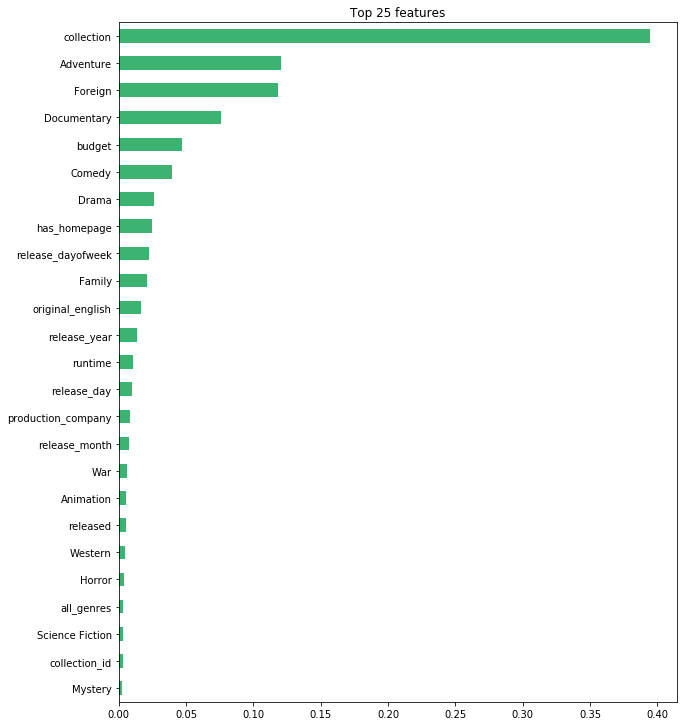

In [99]:
# Get feature importances
importances = pd.Series(model.feature_importances_, X_train.columns)

# Plot feature importances
n = 25
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh(color='mediumseagreen');

In [102]:
import eli5
from eli5.sklearn import PermutationImportance

permuter = PermutationImportance(model, scoring='neg_mean_squared_error', 
                                 cv='prefit', n_iter=2, random_state=42)

permuter.fit(X_val_encoded, y_val_log)
feature_names = X_val_encoded.columns.tolist()
eli5.show_weights(permuter, top=None, feature_names=feature_names)

Weight,Feature
4.3537 ± 0.6159,budget
0.3958 ± 0.2492,production_company
0.3172 ± 0.0812,collection
0.3159 ± 0.1923,release_year
0.2871 ± 0.1313,runtime
0.2256 ± 0.0006,Foreign
0.0904 ± 0.0337,all_genres
0.0776 ± 0.0587,Documentary
0.0543 ± 0.0307,Family
0.0515 ± 0.0049,release_dayofweek


In [105]:
best_features = ['budget', 'production_company', 'collection', 'release_year', 
           'runtime', 'Foreign', 'all_genres', 'Documentary', 'Family',
           'release_dayofweek', 'Animation', 'Comedy', 'Western', 
           'original_english', 'release_month', 'Adventure', 'Mystery',
           'Drama', 'Romance']

In [114]:
X_train_selected = X_train_encoded[best_features]
X_val_selected = X_val_encoded[best_features]
X_test_selected = X_test_encoded[best_features]

In [112]:
eval_set = [(X_train_selected, y_train_log),
            (X_val_selected, y_val_log)]

model = XGBRegressor(n_estimators=10000, n_jobs=-1, eta=0.001, max_depth=2)
model.fit(X_train_selected, y_train_log, eval_set=eval_set, eval_metric='rmse',
         early_stopping_rounds=1000)

[0]	validation_0-rmse:14.2413	validation_1-rmse:14.1132
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 1000 rounds.
[1]	validation_0-rmse:12.8646	validation_1-rmse:12.7412
[2]	validation_0-rmse:11.6299	validation_1-rmse:11.5104
[3]	validation_0-rmse:10.5236	validation_1-rmse:10.4085
[4]	validation_0-rmse:9.53279	validation_1-rmse:9.41729
[5]	validation_0-rmse:8.64519	validation_1-rmse:8.52651
[6]	validation_0-rmse:7.85237	validation_1-rmse:7.73316
[7]	validation_0-rmse:7.14554	validation_1-rmse:7.03078
[8]	validation_0-rmse:6.51671	validation_1-rmse:6.40421
[9]	validation_0-rmse:5.95848	validation_1-rmse:5.84602
[10]	validation_0-rmse:5.46305	validation_1-rmse:5.34749
[11]	validation_0-rmse:5.02553	validation_1-rmse:4.9151
[12]	validation_0-rmse:4.64089	validation_1-rmse:4.52452
[13]	validation_0-rmse:4.30258	validation_1-rmse:4.18817
[14]	validation_0-rmse:4.00767	validation_1-rmse:3.8

[141]	validation_0-rmse:2.07963	validation_1-rmse:2.01108
[142]	validation_0-rmse:2.07187	validation_1-rmse:2.00476
[143]	validation_0-rmse:2.07077	validation_1-rmse:2.00167
[144]	validation_0-rmse:2.06951	validation_1-rmse:2.00086
[145]	validation_0-rmse:2.069	validation_1-rmse:2.00112
[146]	validation_0-rmse:2.06819	validation_1-rmse:2.00171
[147]	validation_0-rmse:2.06178	validation_1-rmse:1.99679
[148]	validation_0-rmse:2.06101	validation_1-rmse:1.99684
[149]	validation_0-rmse:2.05987	validation_1-rmse:1.99684
[150]	validation_0-rmse:2.05961	validation_1-rmse:1.99685
[151]	validation_0-rmse:2.05901	validation_1-rmse:1.99685
[152]	validation_0-rmse:2.05851	validation_1-rmse:1.99676
[153]	validation_0-rmse:2.05297	validation_1-rmse:1.98982
[154]	validation_0-rmse:2.05203	validation_1-rmse:1.98983
[155]	validation_0-rmse:2.05108	validation_1-rmse:1.98712
[156]	validation_0-rmse:2.05043	validation_1-rmse:1.98749
[157]	validation_0-rmse:2.04982	validation_1-rmse:1.9872
[158]	validation_

[283]	validation_0-rmse:1.96206	validation_1-rmse:1.96923
[284]	validation_0-rmse:1.96161	validation_1-rmse:1.96929
[285]	validation_0-rmse:1.9608	validation_1-rmse:1.96913
[286]	validation_0-rmse:1.9602	validation_1-rmse:1.96832
[287]	validation_0-rmse:1.9592	validation_1-rmse:1.96707
[288]	validation_0-rmse:1.95906	validation_1-rmse:1.96707
[289]	validation_0-rmse:1.95872	validation_1-rmse:1.96707
[290]	validation_0-rmse:1.95579	validation_1-rmse:1.96264
[291]	validation_0-rmse:1.95541	validation_1-rmse:1.96292
[292]	validation_0-rmse:1.95471	validation_1-rmse:1.96105
[293]	validation_0-rmse:1.95415	validation_1-rmse:1.9602
[294]	validation_0-rmse:1.95379	validation_1-rmse:1.9602
[295]	validation_0-rmse:1.95343	validation_1-rmse:1.96005
[296]	validation_0-rmse:1.95334	validation_1-rmse:1.96021
[297]	validation_0-rmse:1.95326	validation_1-rmse:1.96022
[298]	validation_0-rmse:1.95274	validation_1-rmse:1.959
[299]	validation_0-rmse:1.95165	validation_1-rmse:1.95924
[300]	validation_0-rm

[425]	validation_0-rmse:1.88776	validation_1-rmse:1.93378
[426]	validation_0-rmse:1.88713	validation_1-rmse:1.93181
[427]	validation_0-rmse:1.88675	validation_1-rmse:1.93173
[428]	validation_0-rmse:1.88624	validation_1-rmse:1.93111
[429]	validation_0-rmse:1.8859	validation_1-rmse:1.93138
[430]	validation_0-rmse:1.88516	validation_1-rmse:1.9314
[431]	validation_0-rmse:1.88484	validation_1-rmse:1.93122
[432]	validation_0-rmse:1.88448	validation_1-rmse:1.93109
[433]	validation_0-rmse:1.88421	validation_1-rmse:1.93128
[434]	validation_0-rmse:1.88388	validation_1-rmse:1.9308
[435]	validation_0-rmse:1.88381	validation_1-rmse:1.93064
[436]	validation_0-rmse:1.88345	validation_1-rmse:1.93068
[437]	validation_0-rmse:1.88281	validation_1-rmse:1.9307
[438]	validation_0-rmse:1.88252	validation_1-rmse:1.93082
[439]	validation_0-rmse:1.88224	validation_1-rmse:1.93068
[440]	validation_0-rmse:1.88189	validation_1-rmse:1.93035
[441]	validation_0-rmse:1.88111	validation_1-rmse:1.93034
[442]	validation_0

[568]	validation_0-rmse:1.83646	validation_1-rmse:1.91866
[569]	validation_0-rmse:1.83544	validation_1-rmse:1.91856
[570]	validation_0-rmse:1.83516	validation_1-rmse:1.91855
[571]	validation_0-rmse:1.83485	validation_1-rmse:1.91855
[572]	validation_0-rmse:1.83396	validation_1-rmse:1.91878
[573]	validation_0-rmse:1.83371	validation_1-rmse:1.91986
[574]	validation_0-rmse:1.83329	validation_1-rmse:1.92103
[575]	validation_0-rmse:1.83276	validation_1-rmse:1.92101
[576]	validation_0-rmse:1.83237	validation_1-rmse:1.92073
[577]	validation_0-rmse:1.8321	validation_1-rmse:1.9215
[578]	validation_0-rmse:1.8315	validation_1-rmse:1.92121
[579]	validation_0-rmse:1.83085	validation_1-rmse:1.92137
[580]	validation_0-rmse:1.83051	validation_1-rmse:1.92131
[581]	validation_0-rmse:1.83037	validation_1-rmse:1.92115
[582]	validation_0-rmse:1.8301	validation_1-rmse:1.9211
[583]	validation_0-rmse:1.82997	validation_1-rmse:1.9209
[584]	validation_0-rmse:1.82958	validation_1-rmse:1.92058
[585]	validation_0-r

[710]	validation_0-rmse:1.78625	validation_1-rmse:1.92136
[711]	validation_0-rmse:1.78593	validation_1-rmse:1.92151
[712]	validation_0-rmse:1.78574	validation_1-rmse:1.92107
[713]	validation_0-rmse:1.78533	validation_1-rmse:1.92117
[714]	validation_0-rmse:1.7851	validation_1-rmse:1.92102
[715]	validation_0-rmse:1.78483	validation_1-rmse:1.92122
[716]	validation_0-rmse:1.78461	validation_1-rmse:1.92119
[717]	validation_0-rmse:1.78425	validation_1-rmse:1.92119
[718]	validation_0-rmse:1.78379	validation_1-rmse:1.92123
[719]	validation_0-rmse:1.78338	validation_1-rmse:1.92126
[720]	validation_0-rmse:1.78325	validation_1-rmse:1.91933
[721]	validation_0-rmse:1.78304	validation_1-rmse:1.91978
[722]	validation_0-rmse:1.78301	validation_1-rmse:1.91978
[723]	validation_0-rmse:1.78261	validation_1-rmse:1.91976
[724]	validation_0-rmse:1.78227	validation_1-rmse:1.91984
[725]	validation_0-rmse:1.78201	validation_1-rmse:1.91988
[726]	validation_0-rmse:1.78173	validation_1-rmse:1.91964
[727]	validatio

[852]	validation_0-rmse:1.74499	validation_1-rmse:1.92438
[853]	validation_0-rmse:1.74474	validation_1-rmse:1.92418
[854]	validation_0-rmse:1.74456	validation_1-rmse:1.92421
[855]	validation_0-rmse:1.74433	validation_1-rmse:1.92332
[856]	validation_0-rmse:1.74431	validation_1-rmse:1.92341
[857]	validation_0-rmse:1.74412	validation_1-rmse:1.92424
[858]	validation_0-rmse:1.74393	validation_1-rmse:1.92481
[859]	validation_0-rmse:1.74362	validation_1-rmse:1.92593
[860]	validation_0-rmse:1.74337	validation_1-rmse:1.92608
[861]	validation_0-rmse:1.74308	validation_1-rmse:1.9261
[862]	validation_0-rmse:1.74295	validation_1-rmse:1.92236
[863]	validation_0-rmse:1.74263	validation_1-rmse:1.92247
[864]	validation_0-rmse:1.74221	validation_1-rmse:1.92266
[865]	validation_0-rmse:1.74178	validation_1-rmse:1.92301
[866]	validation_0-rmse:1.74155	validation_1-rmse:1.92316
[867]	validation_0-rmse:1.74133	validation_1-rmse:1.92255
[868]	validation_0-rmse:1.74117	validation_1-rmse:1.92273
[869]	validatio

[994]	validation_0-rmse:1.69953	validation_1-rmse:1.90901
[995]	validation_0-rmse:1.69951	validation_1-rmse:1.90901
[996]	validation_0-rmse:1.69897	validation_1-rmse:1.90901
[997]	validation_0-rmse:1.69877	validation_1-rmse:1.90905
[998]	validation_0-rmse:1.69859	validation_1-rmse:1.90911
[999]	validation_0-rmse:1.69832	validation_1-rmse:1.90911
[1000]	validation_0-rmse:1.69817	validation_1-rmse:1.90832
[1001]	validation_0-rmse:1.69726	validation_1-rmse:1.90819
[1002]	validation_0-rmse:1.69662	validation_1-rmse:1.90728
[1003]	validation_0-rmse:1.69628	validation_1-rmse:1.90705
[1004]	validation_0-rmse:1.69609	validation_1-rmse:1.90696
[1005]	validation_0-rmse:1.69589	validation_1-rmse:1.90701
[1006]	validation_0-rmse:1.69562	validation_1-rmse:1.90684
[1007]	validation_0-rmse:1.69541	validation_1-rmse:1.90694
[1008]	validation_0-rmse:1.69507	validation_1-rmse:1.90701
[1009]	validation_0-rmse:1.69496	validation_1-rmse:1.90701
[1010]	validation_0-rmse:1.69487	validation_1-rmse:1.90698
[10

[1134]	validation_0-rmse:1.65812	validation_1-rmse:1.90431
[1135]	validation_0-rmse:1.65796	validation_1-rmse:1.90564
[1136]	validation_0-rmse:1.65723	validation_1-rmse:1.9056
[1137]	validation_0-rmse:1.65698	validation_1-rmse:1.90444
[1138]	validation_0-rmse:1.65668	validation_1-rmse:1.9045
[1139]	validation_0-rmse:1.6566	validation_1-rmse:1.90452
[1140]	validation_0-rmse:1.65648	validation_1-rmse:1.90473
[1141]	validation_0-rmse:1.65628	validation_1-rmse:1.90478
[1142]	validation_0-rmse:1.65617	validation_1-rmse:1.90499
[1143]	validation_0-rmse:1.65606	validation_1-rmse:1.90505
[1144]	validation_0-rmse:1.65595	validation_1-rmse:1.90503
[1145]	validation_0-rmse:1.65545	validation_1-rmse:1.90516
[1146]	validation_0-rmse:1.65487	validation_1-rmse:1.90436
[1147]	validation_0-rmse:1.65464	validation_1-rmse:1.90413
[1148]	validation_0-rmse:1.65442	validation_1-rmse:1.90551
[1149]	validation_0-rmse:1.65413	validation_1-rmse:1.90633
[1150]	validation_0-rmse:1.65397	validation_1-rmse:1.90622


[1274]	validation_0-rmse:1.61776	validation_1-rmse:1.91703
[1275]	validation_0-rmse:1.61681	validation_1-rmse:1.91678
[1276]	validation_0-rmse:1.61638	validation_1-rmse:1.9166
[1277]	validation_0-rmse:1.61603	validation_1-rmse:1.91646
[1278]	validation_0-rmse:1.61582	validation_1-rmse:1.91677
[1279]	validation_0-rmse:1.61578	validation_1-rmse:1.91678
[1280]	validation_0-rmse:1.61564	validation_1-rmse:1.91751
[1281]	validation_0-rmse:1.61553	validation_1-rmse:1.91757
[1282]	validation_0-rmse:1.61543	validation_1-rmse:1.91755
[1283]	validation_0-rmse:1.61512	validation_1-rmse:1.91758
[1284]	validation_0-rmse:1.6151	validation_1-rmse:1.91758
[1285]	validation_0-rmse:1.61484	validation_1-rmse:1.91792
[1286]	validation_0-rmse:1.61476	validation_1-rmse:1.91808
[1287]	validation_0-rmse:1.61463	validation_1-rmse:1.91822
[1288]	validation_0-rmse:1.6145	validation_1-rmse:1.91821
[1289]	validation_0-rmse:1.61432	validation_1-rmse:1.91914
[1290]	validation_0-rmse:1.61348	validation_1-rmse:1.91964


[1414]	validation_0-rmse:1.5868	validation_1-rmse:1.92645
[1415]	validation_0-rmse:1.58676	validation_1-rmse:1.92646
[1416]	validation_0-rmse:1.58661	validation_1-rmse:1.92628
[1417]	validation_0-rmse:1.58633	validation_1-rmse:1.92615
[1418]	validation_0-rmse:1.58599	validation_1-rmse:1.92623
[1419]	validation_0-rmse:1.58586	validation_1-rmse:1.92629
[1420]	validation_0-rmse:1.58567	validation_1-rmse:1.92685
[1421]	validation_0-rmse:1.58548	validation_1-rmse:1.92683
[1422]	validation_0-rmse:1.58536	validation_1-rmse:1.92738
[1423]	validation_0-rmse:1.58519	validation_1-rmse:1.92696
[1424]	validation_0-rmse:1.58503	validation_1-rmse:1.92694
[1425]	validation_0-rmse:1.58484	validation_1-rmse:1.92697
[1426]	validation_0-rmse:1.58458	validation_1-rmse:1.92752
[1427]	validation_0-rmse:1.58442	validation_1-rmse:1.9276
[1428]	validation_0-rmse:1.58421	validation_1-rmse:1.92813
[1429]	validation_0-rmse:1.58353	validation_1-rmse:1.92825
[1430]	validation_0-rmse:1.58338	validation_1-rmse:1.92758

[1554]	validation_0-rmse:1.55904	validation_1-rmse:1.9346
[1555]	validation_0-rmse:1.5589	validation_1-rmse:1.93583
[1556]	validation_0-rmse:1.55875	validation_1-rmse:1.93617
[1557]	validation_0-rmse:1.55858	validation_1-rmse:1.93617
[1558]	validation_0-rmse:1.55847	validation_1-rmse:1.93609
[1559]	validation_0-rmse:1.55832	validation_1-rmse:1.93495
[1560]	validation_0-rmse:1.55817	validation_1-rmse:1.9347
[1561]	validation_0-rmse:1.55803	validation_1-rmse:1.93528
[1562]	validation_0-rmse:1.55791	validation_1-rmse:1.93564
[1563]	validation_0-rmse:1.55776	validation_1-rmse:1.93575
[1564]	validation_0-rmse:1.55763	validation_1-rmse:1.9359
[1565]	validation_0-rmse:1.55752	validation_1-rmse:1.93621
[1566]	validation_0-rmse:1.55737	validation_1-rmse:1.93578
[1567]	validation_0-rmse:1.55722	validation_1-rmse:1.93622
[1568]	validation_0-rmse:1.55701	validation_1-rmse:1.93629
[1569]	validation_0-rmse:1.55683	validation_1-rmse:1.93625
[1570]	validation_0-rmse:1.55668	validation_1-rmse:1.93647
[

[1694]	validation_0-rmse:1.53563	validation_1-rmse:1.9327
[1695]	validation_0-rmse:1.53549	validation_1-rmse:1.93323
[1696]	validation_0-rmse:1.5354	validation_1-rmse:1.93353
[1697]	validation_0-rmse:1.53538	validation_1-rmse:1.93354
[1698]	validation_0-rmse:1.53516	validation_1-rmse:1.93358
[1699]	validation_0-rmse:1.53505	validation_1-rmse:1.93381
[1700]	validation_0-rmse:1.53501	validation_1-rmse:1.93395
[1701]	validation_0-rmse:1.53496	validation_1-rmse:1.93298
[1702]	validation_0-rmse:1.53486	validation_1-rmse:1.93317
[1703]	validation_0-rmse:1.5343	validation_1-rmse:1.93328
[1704]	validation_0-rmse:1.53418	validation_1-rmse:1.93331
[1705]	validation_0-rmse:1.53416	validation_1-rmse:1.93332
[1706]	validation_0-rmse:1.53406	validation_1-rmse:1.93316
[1707]	validation_0-rmse:1.53403	validation_1-rmse:1.93329
[1708]	validation_0-rmse:1.53401	validation_1-rmse:1.93329
[1709]	validation_0-rmse:1.53385	validation_1-rmse:1.93375
[1710]	validation_0-rmse:1.53374	validation_1-rmse:1.93358


[1834]	validation_0-rmse:1.51471	validation_1-rmse:1.93429
[1835]	validation_0-rmse:1.51457	validation_1-rmse:1.93505
[1836]	validation_0-rmse:1.51448	validation_1-rmse:1.93462
[1837]	validation_0-rmse:1.51435	validation_1-rmse:1.9348
[1838]	validation_0-rmse:1.51415	validation_1-rmse:1.93373
[1839]	validation_0-rmse:1.51398	validation_1-rmse:1.93371
[1840]	validation_0-rmse:1.51395	validation_1-rmse:1.9337
[1841]	validation_0-rmse:1.51385	validation_1-rmse:1.93435
[1842]	validation_0-rmse:1.51378	validation_1-rmse:1.93438
[1843]	validation_0-rmse:1.51371	validation_1-rmse:1.93466
[1844]	validation_0-rmse:1.51359	validation_1-rmse:1.93469
[1845]	validation_0-rmse:1.51349	validation_1-rmse:1.93479
[1846]	validation_0-rmse:1.51338	validation_1-rmse:1.93484
[1847]	validation_0-rmse:1.51318	validation_1-rmse:1.93481
[1848]	validation_0-rmse:1.513	validation_1-rmse:1.93364
[1849]	validation_0-rmse:1.51265	validation_1-rmse:1.93346
[1850]	validation_0-rmse:1.51249	validation_1-rmse:1.93318
[

[1974]	validation_0-rmse:1.48707	validation_1-rmse:1.93397
[1975]	validation_0-rmse:1.48696	validation_1-rmse:1.93394
[1976]	validation_0-rmse:1.48679	validation_1-rmse:1.93398
[1977]	validation_0-rmse:1.48631	validation_1-rmse:1.93443
[1978]	validation_0-rmse:1.48619	validation_1-rmse:1.93438
[1979]	validation_0-rmse:1.48599	validation_1-rmse:1.93439
[1980]	validation_0-rmse:1.48596	validation_1-rmse:1.9344
[1981]	validation_0-rmse:1.48585	validation_1-rmse:1.93445
[1982]	validation_0-rmse:1.48578	validation_1-rmse:1.93437
[1983]	validation_0-rmse:1.4857	validation_1-rmse:1.9343
[1984]	validation_0-rmse:1.48559	validation_1-rmse:1.93464
[1985]	validation_0-rmse:1.48551	validation_1-rmse:1.93461
[1986]	validation_0-rmse:1.48529	validation_1-rmse:1.93462
[1987]	validation_0-rmse:1.48511	validation_1-rmse:1.93436
[1988]	validation_0-rmse:1.48493	validation_1-rmse:1.93436
[1989]	validation_0-rmse:1.48484	validation_1-rmse:1.93422
[1990]	validation_0-rmse:1.48469	validation_1-rmse:1.93434


[2114]	validation_0-rmse:1.46506	validation_1-rmse:1.93132
[2115]	validation_0-rmse:1.46495	validation_1-rmse:1.93131
[2116]	validation_0-rmse:1.46487	validation_1-rmse:1.93188
[2117]	validation_0-rmse:1.46479	validation_1-rmse:1.93216
[2118]	validation_0-rmse:1.46463	validation_1-rmse:1.93217
[2119]	validation_0-rmse:1.46458	validation_1-rmse:1.93216
[2120]	validation_0-rmse:1.46409	validation_1-rmse:1.93217
[2121]	validation_0-rmse:1.464	validation_1-rmse:1.93225
[2122]	validation_0-rmse:1.46385	validation_1-rmse:1.93249
[2123]	validation_0-rmse:1.46372	validation_1-rmse:1.9325
[2124]	validation_0-rmse:1.46287	validation_1-rmse:1.93248
[2125]	validation_0-rmse:1.46244	validation_1-rmse:1.93246
[2126]	validation_0-rmse:1.46211	validation_1-rmse:1.93241
[2127]	validation_0-rmse:1.46191	validation_1-rmse:1.93241
[2128]	validation_0-rmse:1.46184	validation_1-rmse:1.93267
[2129]	validation_0-rmse:1.4617	validation_1-rmse:1.93279
Stopping. Best iteration:
[1129]	validation_0-rmse:1.65991	v

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eta=0.001, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=2,
       min_child_weight=1, missing=None, n_estimators=10000, n_jobs=-1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)

In [115]:
# Kaggle RMSLE: 
generate_xgb_submission(model, X_test_selected, 1129, 'tmdb_sub_14.csv')

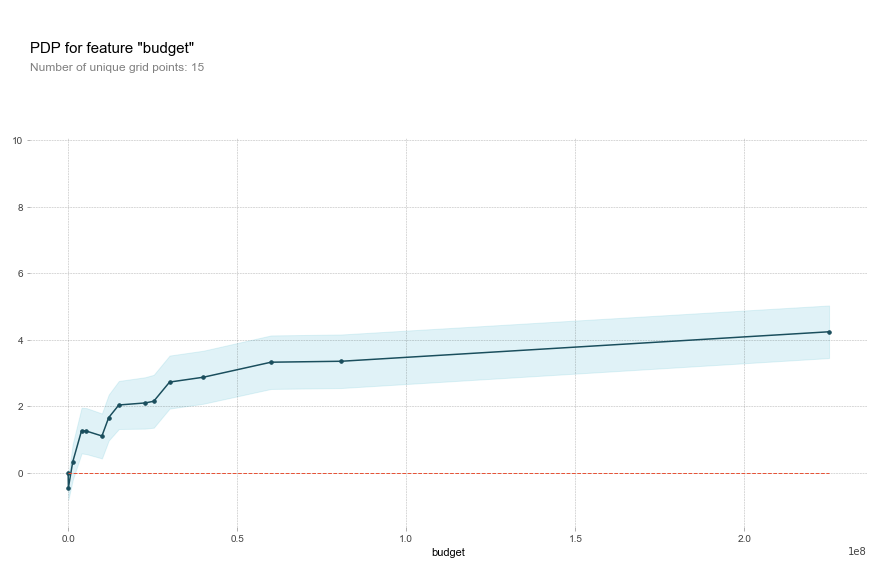

In [134]:
from pdpbox.pdp import pdp_isolate, pdp_plot

feature = 'budget'

isolated = pdp_isolate(
    model=model, 
    dataset=X_val_selected, 
    model_features=X_val_selected.columns, 
    feature=feature, 
    num_grid_points=20
)

pdp_plot(isolated, feature_name=feature);

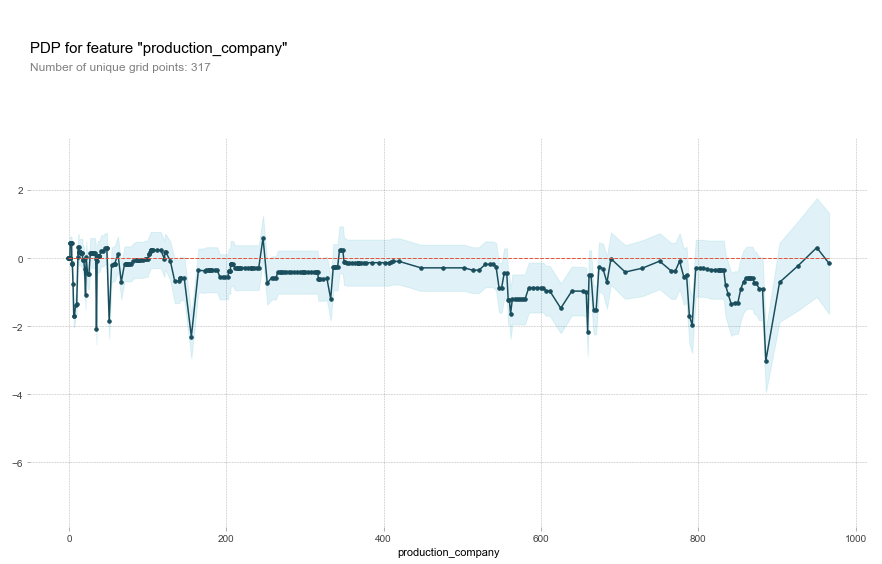

In [131]:
feature = 'production_company'

isolated = pdp_isolate(
    model=model, 
    dataset=X_val_selected, 
    model_features=X_val_selected.columns, 
    feature=feature, 
    num_grid_points=1000
)

pdp_plot(isolated, feature_name=feature);

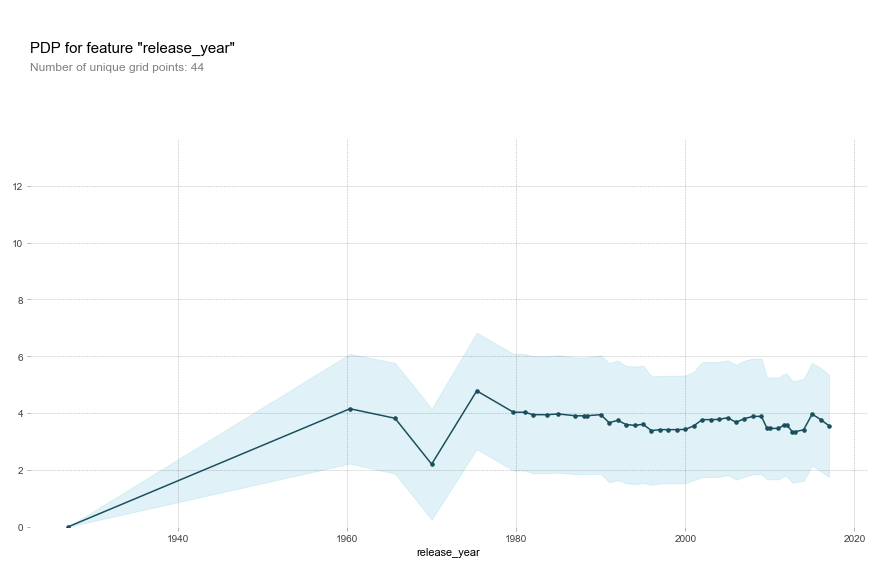

In [136]:
feature = 'release_year'

isolated = pdp_isolate(
    model=model, 
    dataset=X_val_selected, 
    model_features=X_val_selected.columns, 
    feature=feature, 
    num_grid_points=70
)

pdp_plot(isolated, feature_name=feature);

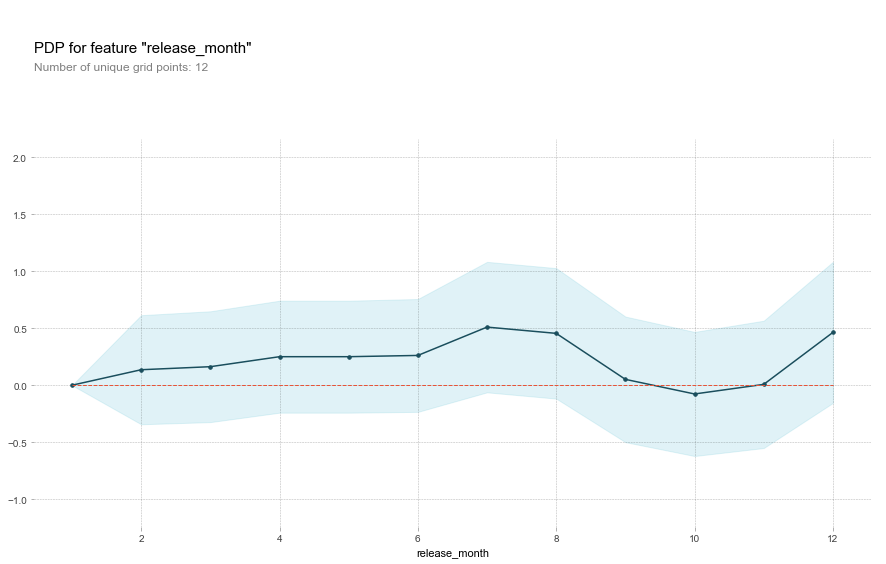

In [138]:
feature = 'release_month'

isolated = pdp_isolate(
    model=model, 
    dataset=X_val_selected, 
    model_features=X_val_selected.columns, 
    feature=feature, 
    num_grid_points=15
)

pdp_plot(isolated, feature_name=feature);

In [150]:
# Is September a 'dump month?'
# Conventional wisdom is that back to school shopping competes for the money
# And football competes for the attention

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
train_wrangled[(train_wrangled['release_month']==8) & (train_wrangled['revenue']>50000000)][['original_title', 'budget', 'revenue', 'release_year']]

,original_title,budget,revenue,release_year
1,The Princess Diaries 2: Royal Engagement,40000000,95149435,2004
6,The Possession,14000000,85446075,2012
16,Red Eye,26000000,57891803,2005
19,Transporter 2,32000000,85167639,2005
34,Rush Hour 3,140000000,258022233,2007
120,Rush Hour 2,90000000,347325802,2001
147,Snowpiercer,39200000,86758912,2013
216,STAND BY ME ドラえもん,35000000,83061158,2014
271,Talladega Nights: The Ballad of Ricky Bobby,72500000,162966177,2006
279,Collateral,65000000,217764291,2004


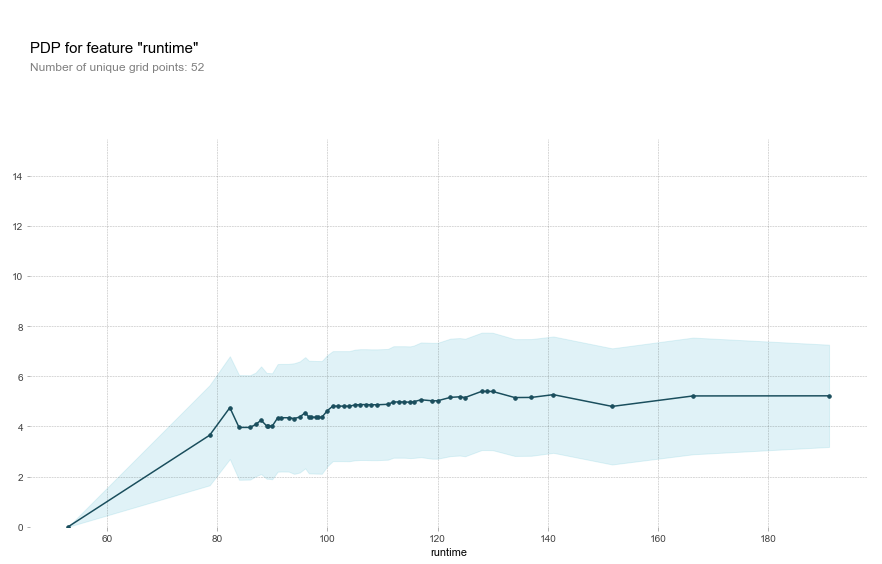

In [151]:
# Sweet spot seems to be ~130 minutes
# 75 minutes is the SAG cutoff to be counted as a feature film, 
# so the rapid increase up to this point makes sense

feature = 'runtime'

isolated = pdp_isolate(
    model=model, 
    dataset=X_val_selected, 
    model_features=X_val_selected.columns, 
    feature=feature, 
    num_grid_points=70
)

pdp_plot(isolated, feature_name=feature);

In [1]:
# Foreign films don't do as well at the box office
feature = 'Foreign'

isolated = pdp_isolate(
    model=model, 
    dataset=X_val_selected, 
    model_features=X_val_selected.columns, 
    feature=feature, 
    num_grid_points=2
)

pdp_plot(isolated, feature_name=feature);

NameError: name 'pdp_isolate' is not defined

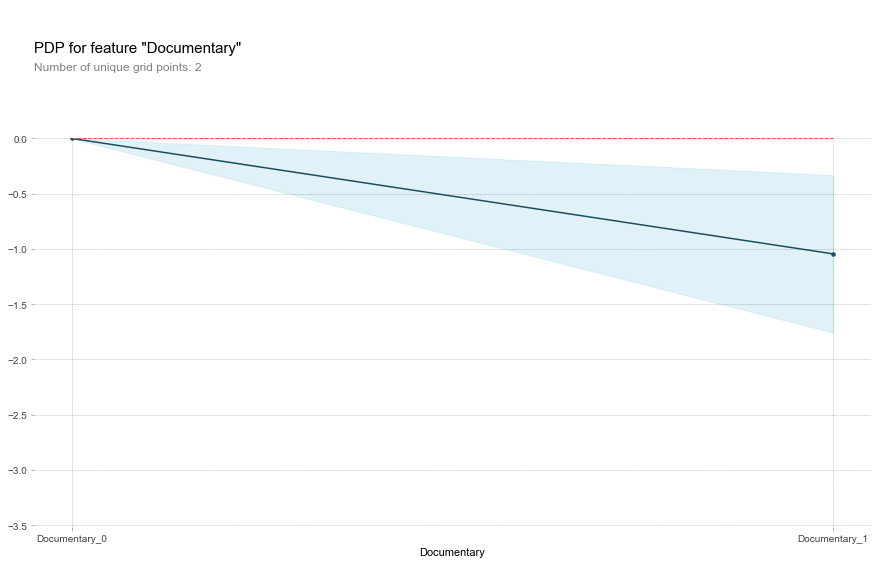

In [154]:
# Neither do documentaries. But not as bad as Foreign.
feature = 'Documentary'

isolated = pdp_isolate(
    model=model, 
    dataset=X_val_selected, 
    model_features=X_val_selected.columns, 
    feature=feature, 
    num_grid_points=70
)

pdp_plot(isolated, feature_name=feature);

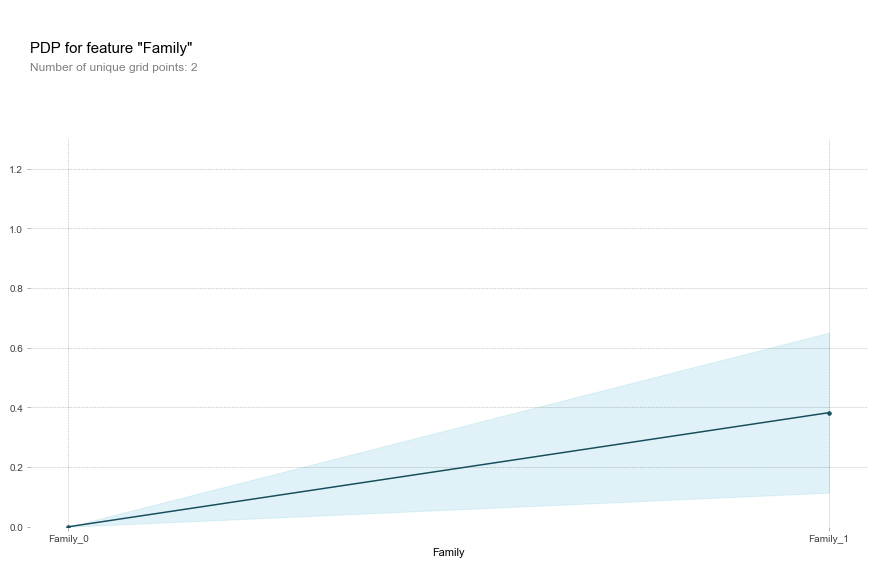

In [155]:
# Being a Family movie lends a moderate bump
feature = 'Family'

isolated = pdp_isolate(
    model=model, 
    dataset=X_val_selected, 
    model_features=X_val_selected.columns, 
    feature=feature, 
    num_grid_points=70
)

pdp_plot(isolated, feature_name=feature);

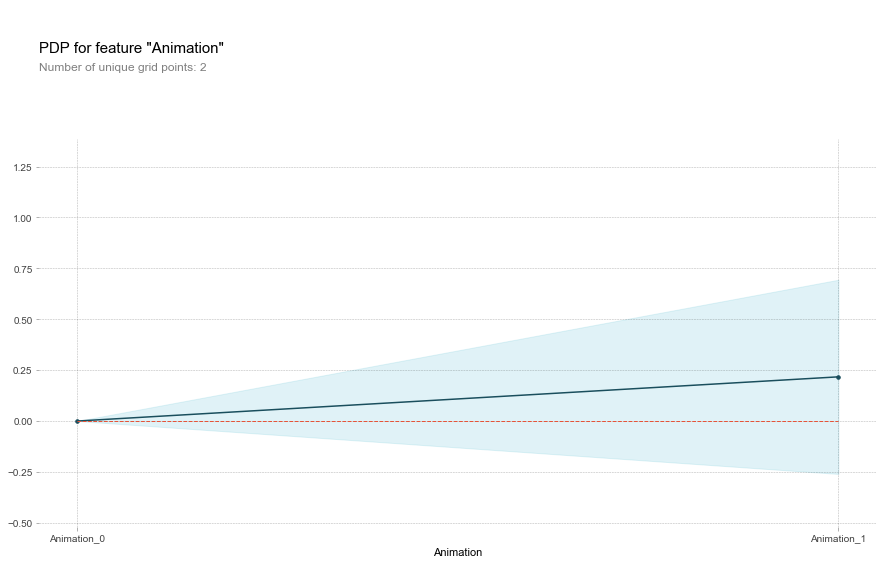

In [156]:
# Animation gives a slight box office bump
feature = 'Animation'

isolated = pdp_isolate(
    model=model, 
    dataset=X_val_selected, 
    model_features=X_val_selected.columns, 
    feature=feature, 
    num_grid_points=70
)

pdp_plot(isolated, feature_name=feature);

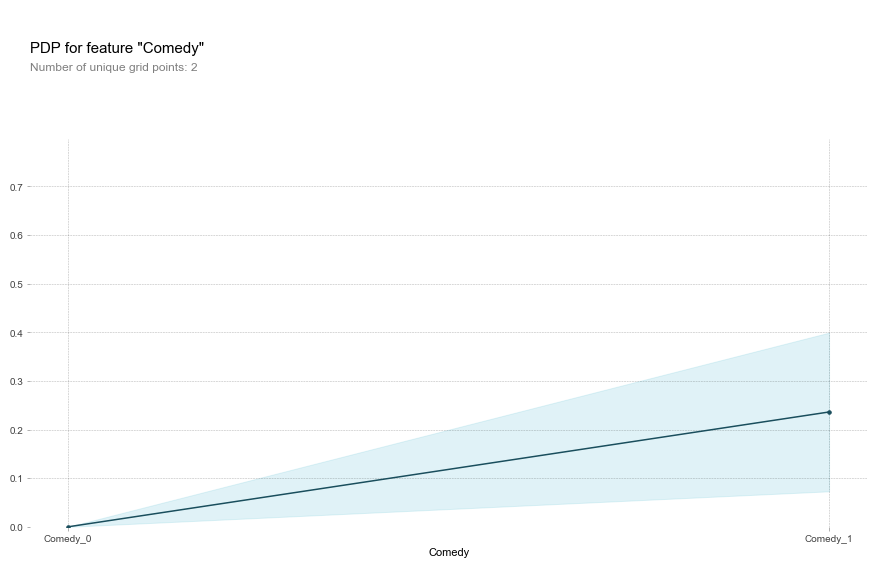

In [157]:
# Slight bump for comedy as well
feature = 'Comedy'

isolated = pdp_isolate(
    model=model, 
    dataset=X_val_selected, 
    model_features=X_val_selected.columns, 
    feature=feature, 
    num_grid_points=70
)

pdp_plot(isolated, feature_name=feature);

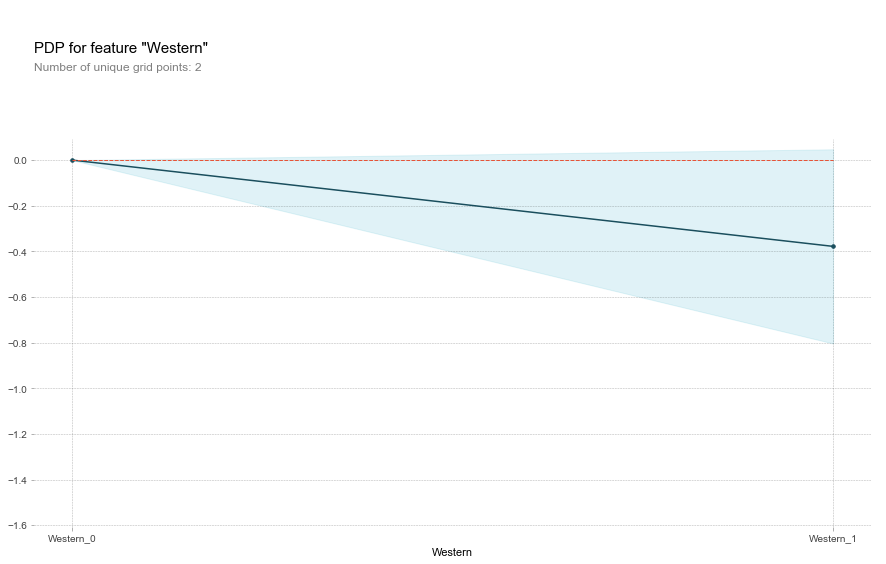

In [158]:
# Looks like the Western may be dead
feature = 'Western'

isolated = pdp_isolate(
    model=model, 
    dataset=X_val_selected, 
    model_features=X_val_selected.columns, 
    feature=feature, 
    num_grid_points=70
)

pdp_plot(isolated, feature_name=feature);

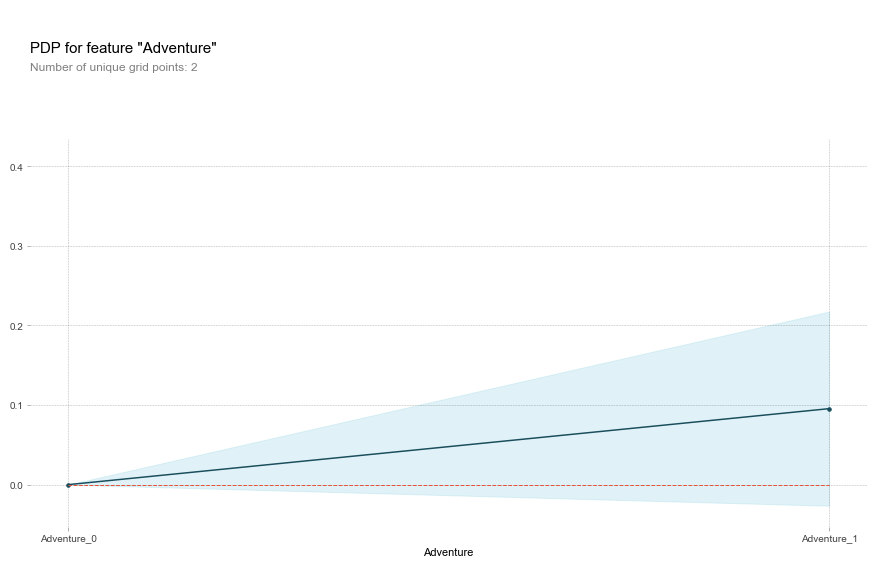

In [159]:
# Slight bump. I thought it would be greater, since so many superhero
# blockbusters are Action|Adventure|Sci-fi. But the model probably picked
# up on other features that covary with genre.
feature = 'Adventure'

isolated = pdp_isolate(
    model=model, 
    dataset=X_val_selected, 
    model_features=X_val_selected.columns, 
    feature=feature, 
    num_grid_points=70
)

pdp_plot(isolated, feature_name=feature);

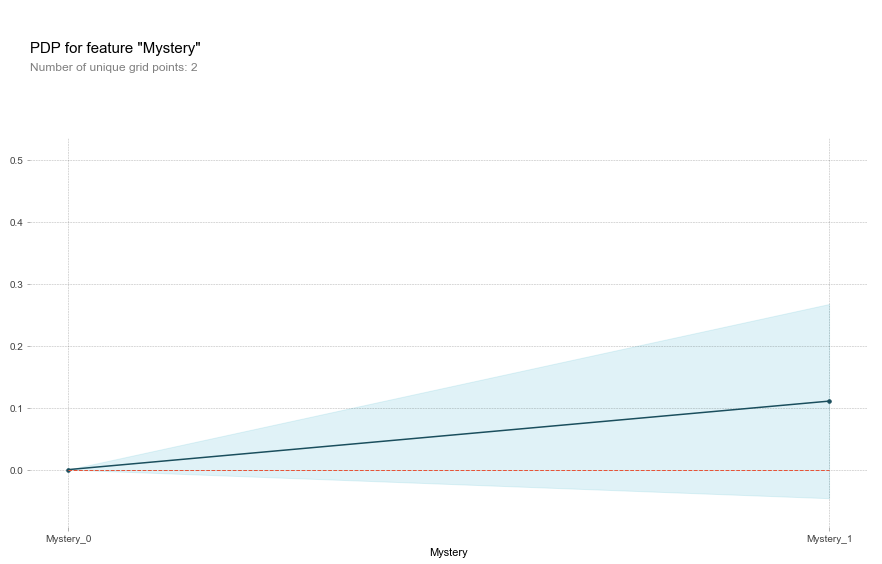

In [160]:
# Small bump for Mystery. Interesting.
feature = 'Mystery'

isolated = pdp_isolate(
    model=model, 
    dataset=X_val_selected, 
    model_features=X_val_selected.columns, 
    feature=feature, 
    num_grid_points=70
)

pdp_plot(isolated, feature_name=feature);

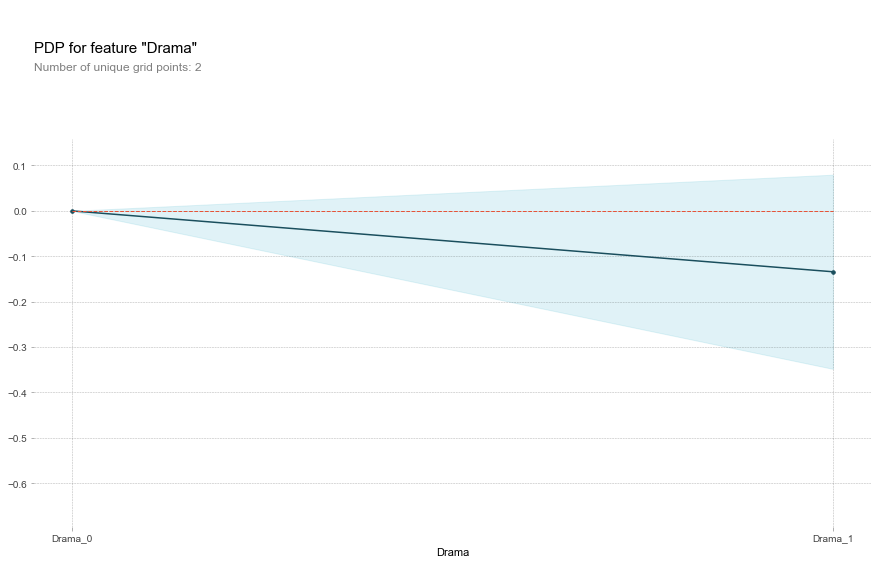

In [161]:
# Drama won't help your box office haul
feature = 'Drama'

isolated = pdp_isolate(
    model=model, 
    dataset=X_val_selected, 
    model_features=X_val_selected.columns, 
    feature=feature, 
    num_grid_points=70
)

pdp_plot(isolated, feature_name=feature);

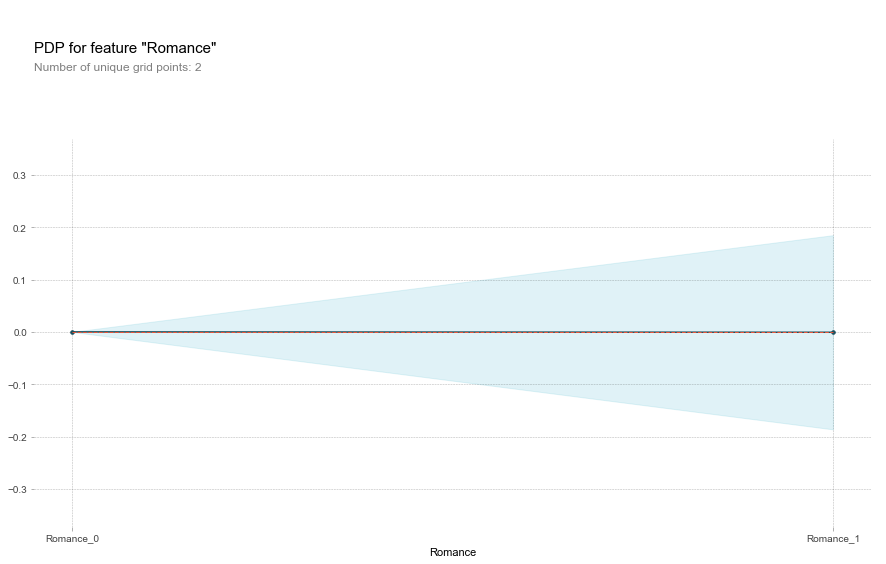

In [162]:
# Romance doensn't seem to have any appreciable effect.
feature = 'Romance'

isolated = pdp_isolate(
    model=model, 
    dataset=X_val_selected, 
    model_features=X_val_selected.columns, 
    feature=feature, 
    num_grid_points=70
)

pdp_plot(isolated, feature_name=feature);

In [ ]:

from sklearn.linear_model import LinearRegression

reg = LinearRegression().fit(X_train_selected, y_train_log)
reg.score(X_train_selected, y_train_log)

In [ ]:
>>> reg.coef_
array([1., 2.])
>>> reg.intercept_ 
3.0000...
>>> reg.predict(np.array([[3, 5]]))
array([16.])